In [4]:
from keras_preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Input,Conv2D,LeakyReLU,Flatten,Dropout,Dense,Reshape,Conv2DTranspose,BatchNormalization
import tensorflow as tf

In [7]:
root_dir = "C:/Users/Mask/Desktop/AIML Projects/Semi -Supervised GANS for Melanoma Detection/MelanomaDetection"

In [14]:
unlabeled_data_gen = ImageDataGenerator(rotation_range=90,brightness_range=(0.5,1),horizontal_flip=True,vertical_flip=True,rescale=1.0/255.0)

In [15]:
unlabeled_datagen = unlabeled_data_gen.flow_from_directory(directory=root_dir,
                                                           target_size=(32,32),classes=['unlabeled'],batch_size=256)

Found 7018 images belonging to 1 classes.


In [16]:
def discriminator():

  dis = Sequential(name="Discriminator")

  dis.add(Conv2D(filters=64,kernel_size=4,strides=2,padding="same",input_shape=(32,32,3),use_bias=False))
  dis.add(LeakyReLU(alpha=0.2))

  dis.add(Conv2D(filters=128,kernel_size=4,strides=2,padding="same",use_bias=False))
  dis.add(BatchNormalization())
  dis.add(LeakyReLU(alpha=0.2))

  dis.add(Conv2D(filters=256,kernel_size=4,strides=2,padding="same",use_bias=False))
  dis.add(BatchNormalization())
  dis.add(LeakyReLU(alpha=0.2))

  dis.add(Flatten())
  dis.add(Dropout(0.4))

  dis.add(Dense(units=1,activation="sigmoid"))

  return dis

In [17]:
def generator():

  noise_shape = 100
  gen = Sequential(name="Generator")

  gen.add(Input(shape=(noise_shape,)))
  gen.add(Dense(units=4*4*100))
  gen.add(Reshape((4,4,100)))

  gen.add(Conv2DTranspose(filters=256,kernel_size=4,strides=1,padding="same",use_bias=False))
  gen.add(BatchNormalization())
  gen.add(LeakyReLU(alpha=0.2))

  gen.add(Conv2DTranspose(filters=128,kernel_size=4,strides=2,padding="same",use_bias=False))
  gen.add(BatchNormalization())
  gen.add(LeakyReLU(alpha=0.2))

  gen.add(Conv2DTranspose(filters=64,kernel_size=4,strides=2,padding="same",use_bias=False))
  gen.add(BatchNormalization())
  gen.add(LeakyReLU(alpha=0.2))

  gen.add(Conv2DTranspose(filters=3,kernel_size=4,strides=2,padding="same",activation="tanh",use_bias=False))

  return gen

In [18]:
D = discriminator()

In [19]:
D.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        3072      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         131072    
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 128)        512       
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         524288    
                                                     

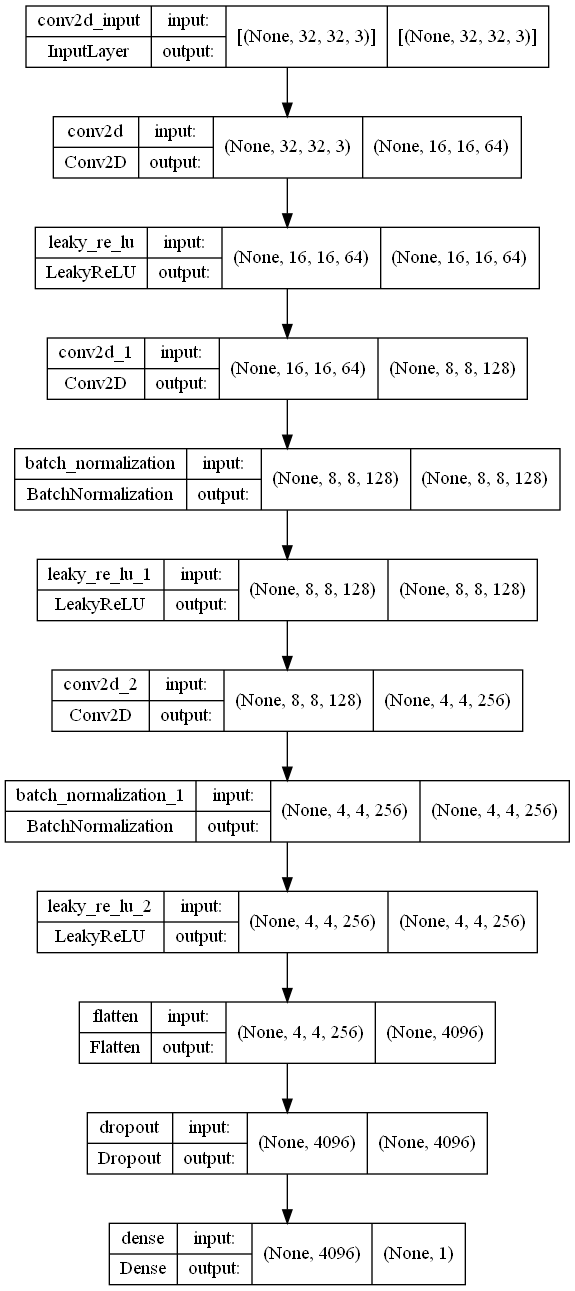

In [20]:
tf.keras.utils.plot_model(model=D,show_shapes=True)

In [21]:
G = generator()

In [22]:
G.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1600)              161600    
                                                                 
 reshape (Reshape)           (None, 4, 4, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 256)        409600    
 nspose)                                                         
                                                                 
 batch_normalization_2 (Batc  (None, 4, 4, 256)        1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 128)        52

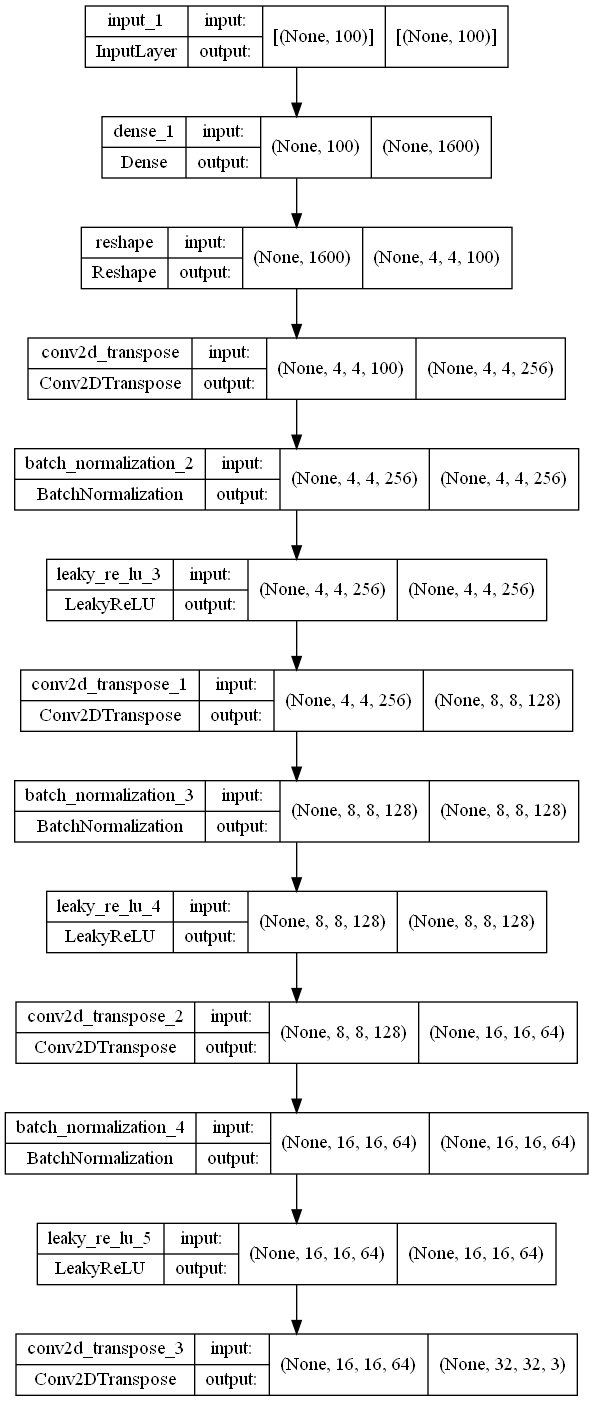

In [23]:
tf.keras.utils.plot_model(model=G,show_shapes=True)

In [24]:
random_noise = tf.random.normal(shape=(1,100))

In [25]:
generated_image = G(random_noise,training=False)

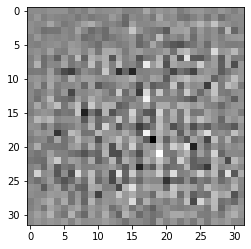

In [26]:
plt.imshow(generated_image[0,:,:,0],cmap='gray')

In [27]:
posterior = D(generated_image)

In [28]:
print(posterior)

tf.Tensor([[0.5004555]], shape=(1, 1), dtype=float32)


In [29]:
GAN_epochs = 50
noise_shape = 100
batch_size = 256

In [30]:
import keras
from IPython import display
import numpy as np

In [31]:
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [32]:
def D_loss(real_imgs_preds,fake_imgs_preds):

  real_imgs_labels = 0.05 * tf.random.uniform(shape=tf.shape(real_imgs_preds)) + tf.ones_like(real_imgs_preds)
  fake_imgs_labels = 0.05 * tf.random.uniform(shape=tf.shape(fake_imgs_preds)) + tf.zeros_like(fake_imgs_preds)

  real_imgs_bce_loss = bce_loss(y_true=real_imgs_labels,y_pred=real_imgs_preds)
  fake_imgs_bce_loss = bce_loss(y_true=fake_imgs_labels,y_pred=fake_imgs_preds)

  total_loss = real_imgs_bce_loss + fake_imgs_bce_loss

  return total_loss

In [33]:
def G_loss(fake_imgs_preds):

  fake_imgs_labels = tf.ones_like(fake_imgs_preds)

  return bce_loss(y_true=fake_imgs_labels,y_pred=fake_imgs_preds)

In [34]:
D_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0008,beta_1=0.3)
G_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0004,beta_1=0.1)

In [35]:
GAN_checkpoint_dir = os.path.join(root_dir ,"Checkpoint")
GAN_checkpoint_prefix = os.path.join(GAN_checkpoint_dir,"ckpt")
GAN_checkpoint = tf.train.Checkpoint(optimizer=[D_optimizer,G_optimizer],model=[D,G])

In [36]:
@tf.function
def training_step(real_imgs_mini_batch):

  G.trainable = False
  noise = tf.random.normal(shape=(batch_size,noise_shape))
  generated_imgs_mini_batch = G(noise,training=False)

  D.trainable = True

  with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:

    real_imgs_preds = D(real_imgs_mini_batch,training=True)
    fake_imgs_preds = D(generated_imgs_mini_batch,training=True)

    disc_loss = D_loss(real_imgs_preds,fake_imgs_preds)

    gradients_of_disc = disc_tape.gradient(disc_loss,D.trainable_variables)
    D_optimizer.apply_gradients(zip(gradients_of_disc,D.trainable_variables))

    D.trainable = False
    G.trainable = True

    #noise = tf.random.normal(shape=(batch_size,noise_shape))
    #generated_imgs_mini_batch = G(noise,training=True)

    #fake_imgs_preds = D(generated_imgs_mini_batch,training=False)

    gen_loss = G_loss(fake_imgs_preds)

    gradients_of_gen = gen_tape.gradient(gen_loss,G.trainable_variables)
    G_optimizer.apply_gradients(zip(gradients_of_gen,G.trainable_variables))

    print("Ran Training Step")

    return disc_loss,gen_loss

In [37]:
constant_noise = tf.random.normal(shape=(16,noise_shape))

In [38]:
real_imgs_path = os.path.join(root_dir ,"unlabeled")

In [39]:
def generate_and_save_images(generator_model,epoch,test_input):

  generated_sample_images = generator_model(test_input,training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(generated_sample_images.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(generated_sample_images[i,:,:,:])
    plt.axis("off")

  plt.savefig("C:/Users/Mask/Desktop/AIML Projects/Semi -Supervised GANS for Melanoma Detection/MelanomaDetection/Generator fig/Images_at_Epoch_{:04d}.png".format(epoch))
  plt.show()

In [40]:
def train_gan(real_imgs_datagen,total_epochs):

  for epoch in range(total_epochs):

    time_step = 1

    for image_batch in real_imgs_datagen:

      print("Time Step: {}, Epoch: {}".format(time_step,epoch+1))

      with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:

        G.trainable = False
        noise = tf.random.normal(shape=(batch_size,noise_shape))
        generated_imgs_mini_batch = G(noise,training=False)

        D.trainable = True

        real_imgs_preds = D(image_batch[0],training=True)
        fake_imgs_preds = D(generated_imgs_mini_batch,training=True)

        disc_loss = D_loss(real_imgs_preds,fake_imgs_preds)

        gradients_of_disc = disc_tape.gradient(disc_loss,D.trainable_variables)
        D_optimizer.apply_gradients(zip(gradients_of_disc,D.trainable_variables))

        D.trainable = False
        G.trainable = True

        #noise = tf.random.normal(shape=(batch_size,noise_shape))
        #generated_imgs_mini_batch = G(noise,training=True)

        #fake_imgs_preds = D(generated_imgs_mini_batch,training=False)

        gen_loss = G_loss(fake_imgs_preds)

        gradients_of_gen = gen_tape.gradient(gen_loss,G.trainable_variables)
        G_optimizer.apply_gradients(zip(gradients_of_gen,G.trainable_variables))

        print("Discriminator Loss: {}, Generator Loss: {}\n".format(disc_loss,gen_loss))

      if time_step > len(os.listdir(real_imgs_path))//batch_size:
        break

      time_step = time_step + 1

    generate_and_save_images(generator_model=G,epoch=epoch+1,test_input=constant_noise)

    if (epoch + 1) % 5 == 0:
      GAN_checkpoint.save(file_prefix=GAN_checkpoint_prefix)

  generate_and_save_images(generator_model=G,epoch=total_epochs,test_input=constant_noise)

Time Step: 1, Epoch: 1


C:\Users\Mask\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Discriminator Loss: 1.7399331331253052, Generator Loss: 0.9219299554824829

Time Step: 2, Epoch: 1
Discriminator Loss: 0.5042821168899536, Generator Loss: 0.6384801864624023

Time Step: 3, Epoch: 1
Discriminator Loss: -0.21508298814296722, Generator Loss: 2.9440455436706543

Time Step: 4, Epoch: 1
Discriminator Loss: 1.9207795858383179, Generator Loss: 0.14580819010734558

Time Step: 5, Epoch: 1
Discriminator Loss: 0.005084723234176636, Generator Loss: 10.236200332641602

Time Step: 6, Epoch: 1
Discriminator Loss: -0.0932387113571167, Generator Loss: 3.0868799686431885

Time Step: 7, Epoch: 1
Discriminator Loss: 1.6067025661468506, Generator Loss: 0.21120093762874603

Time Step: 8, Epoch: 1
Discriminator Loss: 0.2165752649307251, Generator Loss: 13.135263442993164

Time Step: 9, Epoch: 1
Discriminator Loss: -0.020649686455726624, Generator Loss: 6.826451301574707

Time Step: 10, Epoch: 1
Discriminator Loss: 0.13781914114952087, Generator Loss: 1.2792589664459229

Time Step: 11, Epoch: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 0.3463723659515381, Generator Loss: 1.2671916484832764



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


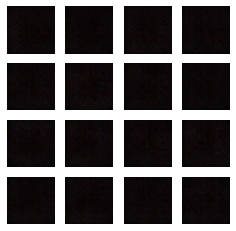

Time Step: 1, Epoch: 2
Discriminator Loss: 0.07985825836658478, Generator Loss: 3.0267701148986816

Time Step: 2, Epoch: 2
Discriminator Loss: 0.18834033608436584, Generator Loss: 2.021036386489868

Time Step: 3, Epoch: 2
Discriminator Loss: 0.15973331034183502, Generator Loss: 2.636251449584961

Time Step: 4, Epoch: 2
Discriminator Loss: 0.3190414011478424, Generator Loss: 1.692226767539978

Time Step: 5, Epoch: 2
Discriminator Loss: 0.4521104395389557, Generator Loss: 4.135430335998535

Time Step: 6, Epoch: 2
Discriminator Loss: 1.8416630029678345, Generator Loss: 0.22287188470363617

Time Step: 7, Epoch: 2
Discriminator Loss: 3.077662944793701, Generator Loss: 13.808046340942383

Time Step: 8, Epoch: 2
Discriminator Loss: -0.025595366954803467, Generator Loss: 2.4296133518218994

Time Step: 9, Epoch: 2
Discriminator Loss: 3.040363311767578, Generator Loss: 0.058070480823516846

Time Step: 10, Epoch: 2
Discriminator Loss: 1.8430055379867554, Generator Loss: 10.694808959960938

Time S

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 0.10225751996040344, Generator Loss: 3.7725088596343994



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


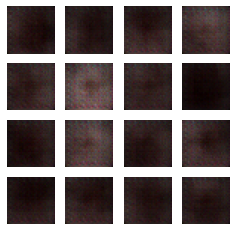

Time Step: 1, Epoch: 3
Discriminator Loss: 0.15736740827560425, Generator Loss: 2.197132110595703

Time Step: 2, Epoch: 3
Discriminator Loss: 0.7759745121002197, Generator Loss: 5.603506088256836

Time Step: 3, Epoch: 3
Discriminator Loss: 3.2693872451782227, Generator Loss: 1.2096552848815918

Time Step: 4, Epoch: 3
Discriminator Loss: 6.566227436065674, Generator Loss: 10.569217681884766

Time Step: 5, Epoch: 3
Discriminator Loss: 0.7094694972038269, Generator Loss: 1.7722992897033691

Time Step: 6, Epoch: 3
Discriminator Loss: 0.23672160506248474, Generator Loss: 2.571481704711914

Time Step: 7, Epoch: 3
Discriminator Loss: 0.2093103677034378, Generator Loss: 3.2622997760772705

Time Step: 8, Epoch: 3
Discriminator Loss: 0.38611072301864624, Generator Loss: 1.395624041557312

Time Step: 9, Epoch: 3
Discriminator Loss: 0.5568623542785645, Generator Loss: 4.20911169052124

Time Step: 10, Epoch: 3
Discriminator Loss: 1.9454421997070312, Generator Loss: 0.23533198237419128

Time Step: 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.9288829565048218, Generator Loss: 5.1516289710998535



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


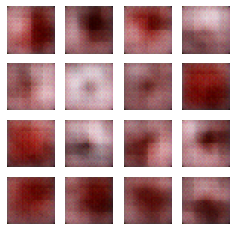

Time Step: 1, Epoch: 4
Discriminator Loss: 0.8033860921859741, Generator Loss: 0.7772915959358215

Time Step: 2, Epoch: 4
Discriminator Loss: 0.5345661640167236, Generator Loss: 2.3208956718444824

Time Step: 3, Epoch: 4
Discriminator Loss: 0.4875161051750183, Generator Loss: 1.744422197341919

Time Step: 4, Epoch: 4
Discriminator Loss: 0.5160132050514221, Generator Loss: 1.5744929313659668

Time Step: 5, Epoch: 4
Discriminator Loss: 0.5177905559539795, Generator Loss: 1.8599363565444946

Time Step: 6, Epoch: 4
Discriminator Loss: 0.5909042358398438, Generator Loss: 1.2565538883209229

Time Step: 7, Epoch: 4
Discriminator Loss: 0.7424631118774414, Generator Loss: 2.4135000705718994

Time Step: 8, Epoch: 4
Discriminator Loss: 1.5202410221099854, Generator Loss: 0.3181925415992737

Time Step: 9, Epoch: 4
Discriminator Loss: 3.661473274230957, Generator Loss: 6.429186820983887

Time Step: 10, Epoch: 4
Discriminator Loss: 2.697793483734131, Generator Loss: 0.09628467261791229

Time Step: 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 2.3875489234924316, Generator Loss: 0.11923839896917343



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


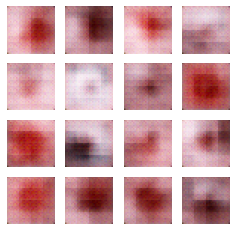

Time Step: 1, Epoch: 5
Discriminator Loss: 1.2739026546478271, Generator Loss: 3.0334978103637695

Time Step: 2, Epoch: 5
Discriminator Loss: 0.916553795337677, Generator Loss: 0.7086145877838135

Time Step: 3, Epoch: 5
Discriminator Loss: 0.722608208656311, Generator Loss: 2.0416927337646484

Time Step: 4, Epoch: 5
Discriminator Loss: 0.6671881079673767, Generator Loss: 1.2463715076446533

Time Step: 5, Epoch: 5
Discriminator Loss: 0.6016438007354736, Generator Loss: 1.5775153636932373

Time Step: 6, Epoch: 5
Discriminator Loss: 0.7250650525093079, Generator Loss: 1.377838134765625

Time Step: 7, Epoch: 5
Discriminator Loss: 0.7247483730316162, Generator Loss: 1.4719170331954956

Time Step: 8, Epoch: 5
Discriminator Loss: 0.6701228618621826, Generator Loss: 1.4124568700790405

Time Step: 9, Epoch: 5
Discriminator Loss: 0.7224932909011841, Generator Loss: 2.001347064971924

Time Step: 10, Epoch: 5
Discriminator Loss: 1.1043634414672852, Generator Loss: 0.7545855045318604

Time Step: 11

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 0.8452951908111572, Generator Loss: 0.9626776576042175



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


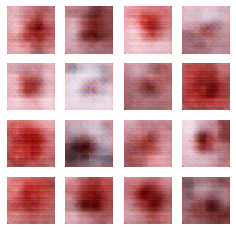

Time Step: 1, Epoch: 6
Discriminator Loss: 0.8328412771224976, Generator Loss: 1.8149161338806152

Time Step: 2, Epoch: 6
Discriminator Loss: 1.1176851987838745, Generator Loss: 0.6303775906562805

Time Step: 3, Epoch: 6
Discriminator Loss: 1.377303957939148, Generator Loss: 2.480247974395752

Time Step: 4, Epoch: 6
Discriminator Loss: 2.0777180194854736, Generator Loss: 0.18503563106060028

Time Step: 5, Epoch: 6
Discriminator Loss: 1.8728644847869873, Generator Loss: 3.4511303901672363

Time Step: 6, Epoch: 6
Discriminator Loss: 1.196441650390625, Generator Loss: 0.5065590143203735

Time Step: 7, Epoch: 6
Discriminator Loss: 0.9122617840766907, Generator Loss: 1.6102633476257324

Time Step: 8, Epoch: 6
Discriminator Loss: 0.8942087888717651, Generator Loss: 1.0190770626068115

Time Step: 9, Epoch: 6
Discriminator Loss: 0.8908074498176575, Generator Loss: 1.1412123441696167

Time Step: 10, Epoch: 6
Discriminator Loss: 0.9465782642364502, Generator Loss: 1.1551955938339233

Time Step: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.9160631895065308, Generator Loss: 0.24098330736160278



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


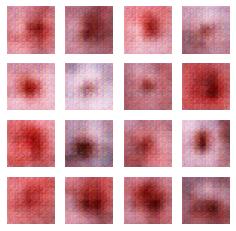

Time Step: 1, Epoch: 7
Discriminator Loss: 3.405177354812622, Generator Loss: 4.498221397399902

Time Step: 2, Epoch: 7
Discriminator Loss: 2.020777702331543, Generator Loss: 0.19489321112632751

Time Step: 3, Epoch: 7
Discriminator Loss: 1.4339308738708496, Generator Loss: 2.1435155868530273

Time Step: 4, Epoch: 7
Discriminator Loss: 1.2862046957015991, Generator Loss: 0.5446298122406006

Time Step: 5, Epoch: 7
Discriminator Loss: 1.017113208770752, Generator Loss: 1.5550438165664673

Time Step: 6, Epoch: 7
Discriminator Loss: 1.0155935287475586, Generator Loss: 0.7952834367752075

Time Step: 7, Epoch: 7
Discriminator Loss: 1.0050580501556396, Generator Loss: 1.37482750415802

Time Step: 8, Epoch: 7
Discriminator Loss: 0.9972757697105408, Generator Loss: 0.7968145608901978

Time Step: 9, Epoch: 7
Discriminator Loss: 1.0214881896972656, Generator Loss: 1.6841343641281128

Time Step: 10, Epoch: 7
Discriminator Loss: 1.3146729469299316, Generator Loss: 0.4389243721961975

Time Step: 11,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.5715532302856445, Generator Loss: 2.3070478439331055



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


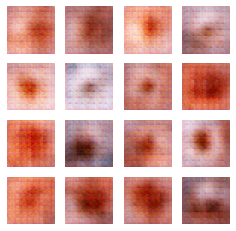

Time Step: 1, Epoch: 8
Discriminator Loss: 1.3138681650161743, Generator Loss: 0.5466873645782471

Time Step: 2, Epoch: 8
Discriminator Loss: 1.079237461090088, Generator Loss: 1.200664758682251

Time Step: 3, Epoch: 8
Discriminator Loss: 1.1721792221069336, Generator Loss: 1.0035221576690674

Time Step: 4, Epoch: 8
Discriminator Loss: 1.183795690536499, Generator Loss: 0.729272723197937

Time Step: 5, Epoch: 8
Discriminator Loss: 1.3514399528503418, Generator Loss: 1.552302360534668

Time Step: 6, Epoch: 8
Discriminator Loss: 1.7677342891693115, Generator Loss: 0.3203098773956299

Time Step: 7, Epoch: 8
Discriminator Loss: 1.7322421073913574, Generator Loss: 2.6479551792144775

Time Step: 8, Epoch: 8
Discriminator Loss: 1.563597321510315, Generator Loss: 0.32442164421081543

Time Step: 9, Epoch: 8
Discriminator Loss: 1.086328148841858, Generator Loss: 2.310842514038086

Time Step: 10, Epoch: 8
Discriminator Loss: 0.988818883895874, Generator Loss: 0.651381254196167

Time Step: 11, Epo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.0642132759094238, Generator Loss: 1.029660940170288



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


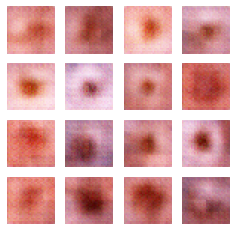

Time Step: 1, Epoch: 9
Discriminator Loss: 1.0121119022369385, Generator Loss: 1.088536024093628

Time Step: 2, Epoch: 9
Discriminator Loss: 1.160555362701416, Generator Loss: 0.9732950329780579

Time Step: 3, Epoch: 9
Discriminator Loss: 1.2005618810653687, Generator Loss: 0.9317029118537903

Time Step: 4, Epoch: 9
Discriminator Loss: 1.241281509399414, Generator Loss: 0.9985507130622864

Time Step: 5, Epoch: 9
Discriminator Loss: 1.2670880556106567, Generator Loss: 0.9075937271118164

Time Step: 6, Epoch: 9
Discriminator Loss: 1.311792016029358, Generator Loss: 0.8250582218170166

Time Step: 7, Epoch: 9
Discriminator Loss: 1.0779962539672852, Generator Loss: 1.1979117393493652

Time Step: 8, Epoch: 9
Discriminator Loss: 1.0648447275161743, Generator Loss: 0.6660588979721069

Time Step: 9, Epoch: 9
Discriminator Loss: 1.3141489028930664, Generator Loss: 2.8786416053771973

Time Step: 10, Epoch: 9
Discriminator Loss: 2.265429735183716, Generator Loss: 0.16902120411396027

Time Step: 11

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.3917295932769775, Generator Loss: 2.132324695587158



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


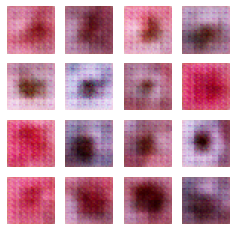

Time Step: 1, Epoch: 10
Discriminator Loss: 2.5780296325683594, Generator Loss: 0.11257192492485046

Time Step: 2, Epoch: 10
Discriminator Loss: 1.5708067417144775, Generator Loss: 2.3637781143188477

Time Step: 3, Epoch: 10
Discriminator Loss: 1.2891209125518799, Generator Loss: 0.5443069934844971

Time Step: 4, Epoch: 10
Discriminator Loss: 1.0746026039123535, Generator Loss: 1.0431468486785889

Time Step: 5, Epoch: 10
Discriminator Loss: 0.9857839345932007, Generator Loss: 1.0751972198486328

Time Step: 6, Epoch: 10
Discriminator Loss: 1.0425355434417725, Generator Loss: 0.9930180311203003

Time Step: 7, Epoch: 10
Discriminator Loss: 1.1183375120162964, Generator Loss: 1.0277436971664429

Time Step: 8, Epoch: 10
Discriminator Loss: 1.310961365699768, Generator Loss: 0.7977249622344971

Time Step: 9, Epoch: 10
Discriminator Loss: 1.6164942979812622, Generator Loss: 0.8347828984260559

Time Step: 10, Epoch: 10
Discriminator Loss: 1.328819990158081, Generator Loss: 1.2583180665969849



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.5110552310943604, Generator Loss: 0.4892553687095642



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


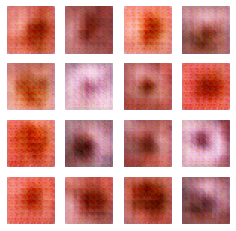

Time Step: 1, Epoch: 11
Discriminator Loss: 1.491001009941101, Generator Loss: 2.124124526977539

Time Step: 2, Epoch: 11
Discriminator Loss: 1.2447659969329834, Generator Loss: 0.5243571996688843

Time Step: 3, Epoch: 11
Discriminator Loss: 1.0461535453796387, Generator Loss: 1.2793059349060059

Time Step: 4, Epoch: 11
Discriminator Loss: 1.3194557428359985, Generator Loss: 0.6474994421005249

Time Step: 5, Epoch: 11
Discriminator Loss: 1.04648756980896, Generator Loss: 1.8890597820281982

Time Step: 6, Epoch: 11
Discriminator Loss: 1.2202523946762085, Generator Loss: 0.49455058574676514

Time Step: 7, Epoch: 11
Discriminator Loss: 1.4995940923690796, Generator Loss: 2.976687431335449

Time Step: 8, Epoch: 11
Discriminator Loss: 2.499404191970825, Generator Loss: 0.11707518994808197

Time Step: 9, Epoch: 11
Discriminator Loss: 1.1870781183242798, Generator Loss: 1.7335307598114014

Time Step: 10, Epoch: 11
Discriminator Loss: 1.0769658088684082, Generator Loss: 0.9358421564102173

Tim

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.0934879779815674, Generator Loss: 0.890789270401001



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


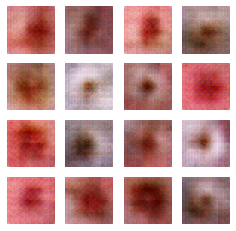

Time Step: 1, Epoch: 12
Discriminator Loss: 1.1884382963180542, Generator Loss: 0.9998044371604919

Time Step: 2, Epoch: 12
Discriminator Loss: 1.373639464378357, Generator Loss: 0.7497406005859375

Time Step: 3, Epoch: 12
Discriminator Loss: 1.3079966306686401, Generator Loss: 1.369335651397705

Time Step: 4, Epoch: 12
Discriminator Loss: 1.4441330432891846, Generator Loss: 0.47852790355682373

Time Step: 5, Epoch: 12
Discriminator Loss: 1.4465538263320923, Generator Loss: 2.3834080696105957

Time Step: 6, Epoch: 12
Discriminator Loss: 1.7787067890167236, Generator Loss: 0.2625495195388794

Time Step: 7, Epoch: 12
Discriminator Loss: 1.2915332317352295, Generator Loss: 2.0768990516662598

Time Step: 8, Epoch: 12
Discriminator Loss: 1.3392947912216187, Generator Loss: 0.4971136748790741

Time Step: 9, Epoch: 12
Discriminator Loss: 1.2876514196395874, Generator Loss: 1.1179510354995728

Time Step: 10, Epoch: 12
Discriminator Loss: 1.3024756908416748, Generator Loss: 0.7155393362045288



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.7168694734573364, Generator Loss: 0.3285626173019409



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


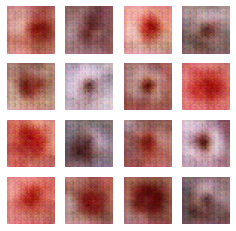

Time Step: 1, Epoch: 13
Discriminator Loss: 1.468310832977295, Generator Loss: 2.080221176147461

Time Step: 2, Epoch: 13
Discriminator Loss: 1.5366398096084595, Generator Loss: 0.39072591066360474

Time Step: 3, Epoch: 13
Discriminator Loss: 1.158247470855713, Generator Loss: 1.4858537912368774

Time Step: 4, Epoch: 13
Discriminator Loss: 1.2002509832382202, Generator Loss: 0.7558959126472473

Time Step: 5, Epoch: 13
Discriminator Loss: 1.1915771961212158, Generator Loss: 0.8932410478591919

Time Step: 6, Epoch: 13
Discriminator Loss: 1.2424345016479492, Generator Loss: 0.9896027445793152

Time Step: 7, Epoch: 13
Discriminator Loss: 1.3878458738327026, Generator Loss: 0.6600360870361328

Time Step: 8, Epoch: 13
Discriminator Loss: 1.3457024097442627, Generator Loss: 1.1537132263183594

Time Step: 9, Epoch: 13
Discriminator Loss: 1.3913815021514893, Generator Loss: 0.5286834239959717

Time Step: 10, Epoch: 13
Discriminator Loss: 1.290523648262024, Generator Loss: 1.8063547611236572

Ti

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.3524572849273682, Generator Loss: 1.3274717330932617



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


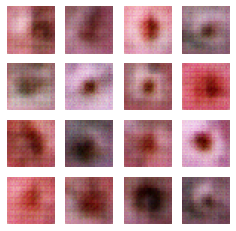

Time Step: 1, Epoch: 14
Discriminator Loss: 1.6478731632232666, Generator Loss: 0.3847754895687103

Time Step: 2, Epoch: 14
Discriminator Loss: 1.7814204692840576, Generator Loss: 2.5893309116363525

Time Step: 3, Epoch: 14
Discriminator Loss: 1.857950210571289, Generator Loss: 0.23649173974990845

Time Step: 4, Epoch: 14
Discriminator Loss: 1.4790648221969604, Generator Loss: 1.6310920715332031

Time Step: 5, Epoch: 14
Discriminator Loss: 1.349048137664795, Generator Loss: 0.5598388314247131

Time Step: 6, Epoch: 14
Discriminator Loss: 1.2773122787475586, Generator Loss: 0.9650201797485352

Time Step: 7, Epoch: 14
Discriminator Loss: 1.2669215202331543, Generator Loss: 0.7737771272659302

Time Step: 8, Epoch: 14
Discriminator Loss: 1.2480528354644775, Generator Loss: 0.8508588075637817

Time Step: 9, Epoch: 14
Discriminator Loss: 1.1931025981903076, Generator Loss: 0.8711957931518555

Time Step: 10, Epoch: 14
Discriminator Loss: 1.1986055374145508, Generator Loss: 0.9566354751586914



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.1133551597595215, Generator Loss: 0.8267896175384521



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


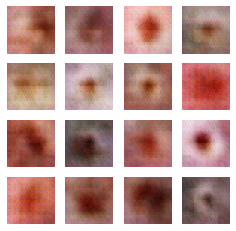

Time Step: 1, Epoch: 15
Discriminator Loss: 1.190954327583313, Generator Loss: 0.8630380630493164

Time Step: 2, Epoch: 15
Discriminator Loss: 1.2250778675079346, Generator Loss: 0.8881612420082092

Time Step: 3, Epoch: 15
Discriminator Loss: 1.2564674615859985, Generator Loss: 0.8209012746810913

Time Step: 4, Epoch: 15
Discriminator Loss: 1.2867822647094727, Generator Loss: 0.8603324294090271

Time Step: 5, Epoch: 15
Discriminator Loss: 1.2644867897033691, Generator Loss: 0.8328235149383545

Time Step: 6, Epoch: 15
Discriminator Loss: 1.1714227199554443, Generator Loss: 0.9921607971191406

Time Step: 7, Epoch: 15
Discriminator Loss: 1.1777873039245605, Generator Loss: 0.6863723397254944

Time Step: 8, Epoch: 15
Discriminator Loss: 1.49054753780365, Generator Loss: 1.9883754253387451

Time Step: 9, Epoch: 15
Discriminator Loss: 2.4995498657226562, Generator Loss: 0.10602274537086487

Time Step: 10, Epoch: 15
Discriminator Loss: 1.63649320602417, Generator Loss: 1.8428614139556885

Tim

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.2957202196121216, Generator Loss: 0.8885884284973145



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


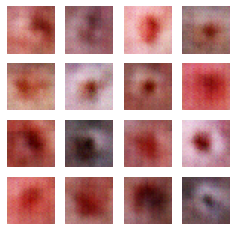

Time Step: 1, Epoch: 16
Discriminator Loss: 1.2000665664672852, Generator Loss: 0.8944501280784607

Time Step: 2, Epoch: 16
Discriminator Loss: 1.236956000328064, Generator Loss: 0.773653507232666

Time Step: 3, Epoch: 16
Discriminator Loss: 1.1995006799697876, Generator Loss: 0.8564749956130981

Time Step: 4, Epoch: 16
Discriminator Loss: 1.2601286172866821, Generator Loss: 0.8104923963546753

Time Step: 5, Epoch: 16
Discriminator Loss: 1.2482795715332031, Generator Loss: 0.8884539604187012

Time Step: 6, Epoch: 16
Discriminator Loss: 1.2517790794372559, Generator Loss: 0.7851590514183044

Time Step: 7, Epoch: 16
Discriminator Loss: 1.2407879829406738, Generator Loss: 0.9538936614990234

Time Step: 8, Epoch: 16
Discriminator Loss: 1.300978660583496, Generator Loss: 0.7419540882110596

Time Step: 9, Epoch: 16
Discriminator Loss: 1.26197350025177, Generator Loss: 0.9810856580734253

Time Step: 10, Epoch: 16
Discriminator Loss: 1.3473159074783325, Generator Loss: 0.6564807295799255

Time

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.4585411548614502, Generator Loss: 0.4411655366420746



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


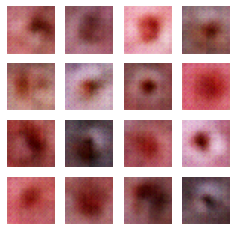

Time Step: 1, Epoch: 17
Discriminator Loss: 1.405836582183838, Generator Loss: 1.3307819366455078

Time Step: 2, Epoch: 17
Discriminator Loss: 1.5545352697372437, Generator Loss: 0.40698614716529846

Time Step: 3, Epoch: 17
Discriminator Loss: 1.4077537059783936, Generator Loss: 1.4419986009597778

Time Step: 4, Epoch: 17
Discriminator Loss: 1.5204670429229736, Generator Loss: 0.3948749303817749

Time Step: 5, Epoch: 17
Discriminator Loss: 1.3002243041992188, Generator Loss: 1.4405479431152344

Time Step: 6, Epoch: 17
Discriminator Loss: 1.348929762840271, Generator Loss: 0.5108311772346497

Time Step: 7, Epoch: 17
Discriminator Loss: 1.326897144317627, Generator Loss: 1.2506179809570312

Time Step: 8, Epoch: 17
Discriminator Loss: 1.3058924674987793, Generator Loss: 0.5661712884902954

Time Step: 9, Epoch: 17
Discriminator Loss: 1.2163971662521362, Generator Loss: 1.3777114152908325

Time Step: 10, Epoch: 17
Discriminator Loss: 1.4919527769088745, Generator Loss: 0.4073418974876404

T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.5630735158920288, Generator Loss: 0.3591572642326355



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


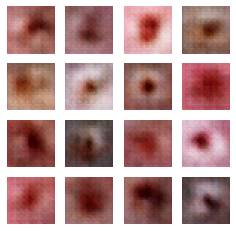

Time Step: 1, Epoch: 18
Discriminator Loss: 1.7585258483886719, Generator Loss: 2.0870554447174072

Time Step: 2, Epoch: 18
Discriminator Loss: 1.6671922206878662, Generator Loss: 0.31542059779167175

Time Step: 3, Epoch: 18
Discriminator Loss: 1.3046895265579224, Generator Loss: 1.0550284385681152

Time Step: 4, Epoch: 18
Discriminator Loss: 1.273759126663208, Generator Loss: 0.7432941794395447

Time Step: 5, Epoch: 18
Discriminator Loss: 1.2622737884521484, Generator Loss: 0.7748184204101562

Time Step: 6, Epoch: 18
Discriminator Loss: 1.2580840587615967, Generator Loss: 0.8085145950317383

Time Step: 7, Epoch: 18
Discriminator Loss: 1.1798092126846313, Generator Loss: 0.9430099129676819

Time Step: 8, Epoch: 18
Discriminator Loss: 1.2268624305725098, Generator Loss: 0.8032075762748718

Time Step: 9, Epoch: 18
Discriminator Loss: 1.2053474187850952, Generator Loss: 1.1113102436065674

Time Step: 10, Epoch: 18
Discriminator Loss: 1.333076000213623, Generator Loss: 0.535534143447876

T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.2273988723754883, Generator Loss: 0.8144564032554626



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


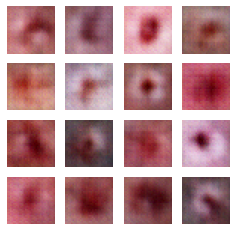

Time Step: 1, Epoch: 19
Discriminator Loss: 1.1401004791259766, Generator Loss: 0.8647376298904419

Time Step: 2, Epoch: 19
Discriminator Loss: 1.1216914653778076, Generator Loss: 1.0480172634124756

Time Step: 3, Epoch: 19
Discriminator Loss: 1.2641267776489258, Generator Loss: 0.605687141418457

Time Step: 4, Epoch: 19
Discriminator Loss: 1.367242693901062, Generator Loss: 1.5127480030059814

Time Step: 5, Epoch: 19
Discriminator Loss: 1.7549583911895752, Generator Loss: 0.2722157835960388

Time Step: 6, Epoch: 19
Discriminator Loss: 1.6447293758392334, Generator Loss: 1.853603482246399

Time Step: 7, Epoch: 19
Discriminator Loss: 1.4088644981384277, Generator Loss: 0.43246573209762573

Time Step: 8, Epoch: 19
Discriminator Loss: 1.1207642555236816, Generator Loss: 1.014728307723999

Time Step: 9, Epoch: 19
Discriminator Loss: 1.2194613218307495, Generator Loss: 0.8984184861183167

Time Step: 10, Epoch: 19
Discriminator Loss: 1.195876121520996, Generator Loss: 0.7054008841514587

Tim

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.4262806177139282, Generator Loss: 0.40791356563568115



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


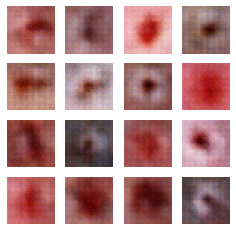

Time Step: 1, Epoch: 20
Discriminator Loss: 1.1591641902923584, Generator Loss: 1.1121926307678223

Time Step: 2, Epoch: 20
Discriminator Loss: 1.1444470882415771, Generator Loss: 0.8276844024658203

Time Step: 3, Epoch: 20
Discriminator Loss: 1.1272624731063843, Generator Loss: 0.9382994174957275

Time Step: 4, Epoch: 20
Discriminator Loss: 1.1138375997543335, Generator Loss: 0.8015267848968506

Time Step: 5, Epoch: 20
Discriminator Loss: 1.1740975379943848, Generator Loss: 1.0212886333465576

Time Step: 6, Epoch: 20
Discriminator Loss: 1.313741683959961, Generator Loss: 0.6270731687545776

Time Step: 7, Epoch: 20
Discriminator Loss: 1.4233827590942383, Generator Loss: 1.428110122680664

Time Step: 8, Epoch: 20
Discriminator Loss: 1.651473879814148, Generator Loss: 0.3012247681617737

Time Step: 9, Epoch: 20
Discriminator Loss: 1.4040398597717285, Generator Loss: 1.8967535495758057

Time Step: 10, Epoch: 20
Discriminator Loss: 1.5695257186889648, Generator Loss: 0.34517502784729004

T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.247729778289795, Generator Loss: 0.9537955522537231



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


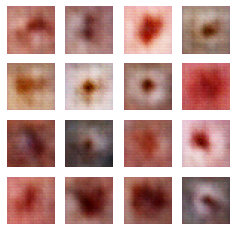

Time Step: 1, Epoch: 21
Discriminator Loss: 1.311165452003479, Generator Loss: 0.624956488609314

Time Step: 2, Epoch: 21
Discriminator Loss: 1.2495595216751099, Generator Loss: 1.237167477607727

Time Step: 3, Epoch: 21
Discriminator Loss: 1.52553391456604, Generator Loss: 0.4044806957244873

Time Step: 4, Epoch: 21
Discriminator Loss: 2.3084819316864014, Generator Loss: 2.756145477294922

Time Step: 5, Epoch: 21
Discriminator Loss: 1.906800627708435, Generator Loss: 0.2187560498714447

Time Step: 6, Epoch: 21
Discriminator Loss: 1.3362476825714111, Generator Loss: 1.7693147659301758

Time Step: 7, Epoch: 21
Discriminator Loss: 1.3039517402648926, Generator Loss: 0.5660931468009949

Time Step: 8, Epoch: 21
Discriminator Loss: 1.2212598323822021, Generator Loss: 0.8545646667480469

Time Step: 9, Epoch: 21
Discriminator Loss: 1.2582143545150757, Generator Loss: 0.7953854203224182

Time Step: 10, Epoch: 21
Discriminator Loss: 1.2364871501922607, Generator Loss: 0.7812901735305786

Time S

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.2257088422775269, Generator Loss: 1.010106086730957



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


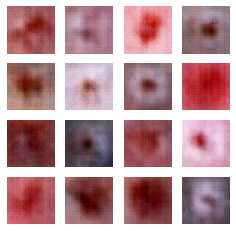

Time Step: 1, Epoch: 22
Discriminator Loss: 1.2016650438308716, Generator Loss: 0.7653365135192871

Time Step: 2, Epoch: 22
Discriminator Loss: 1.2099753618240356, Generator Loss: 0.8265311121940613

Time Step: 3, Epoch: 22
Discriminator Loss: 1.1265560388565063, Generator Loss: 0.8778254389762878

Time Step: 4, Epoch: 22
Discriminator Loss: 1.1102039813995361, Generator Loss: 0.9569805860519409

Time Step: 5, Epoch: 22
Discriminator Loss: 1.2281359434127808, Generator Loss: 0.7452883124351501

Time Step: 6, Epoch: 22
Discriminator Loss: 1.2639232873916626, Generator Loss: 0.975258469581604

Time Step: 7, Epoch: 22
Discriminator Loss: 1.359821081161499, Generator Loss: 0.5453606247901917

Time Step: 8, Epoch: 22
Discriminator Loss: 1.391372799873352, Generator Loss: 1.2934894561767578

Time Step: 9, Epoch: 22
Discriminator Loss: 1.4129588603973389, Generator Loss: 0.4469488263130188

Time Step: 10, Epoch: 22
Discriminator Loss: 1.5827150344848633, Generator Loss: 1.9252606630325317

Ti

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.6623737812042236, Generator Loss: 0.32002943754196167



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


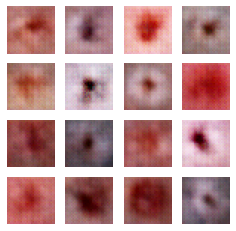

Time Step: 1, Epoch: 23
Discriminator Loss: 1.8952460289001465, Generator Loss: 2.095029830932617

Time Step: 2, Epoch: 23
Discriminator Loss: 1.9221810102462769, Generator Loss: 0.2146473526954651

Time Step: 3, Epoch: 23
Discriminator Loss: 1.2977787256240845, Generator Loss: 1.044368863105774

Time Step: 4, Epoch: 23
Discriminator Loss: 1.2448968887329102, Generator Loss: 0.8925204277038574

Time Step: 5, Epoch: 23
Discriminator Loss: 1.1998062133789062, Generator Loss: 0.6983304023742676

Time Step: 6, Epoch: 23
Discriminator Loss: 1.1626193523406982, Generator Loss: 1.0601634979248047

Time Step: 7, Epoch: 23
Discriminator Loss: 1.2588796615600586, Generator Loss: 0.6224957704544067

Time Step: 8, Epoch: 23
Discriminator Loss: 1.2443504333496094, Generator Loss: 1.313976526260376

Time Step: 9, Epoch: 23
Discriminator Loss: 1.4166111946105957, Generator Loss: 0.41288477182388306

Time Step: 10, Epoch: 23
Discriminator Loss: 1.479164958000183, Generator Loss: 1.6557270288467407

Ti

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.2071218490600586, Generator Loss: 1.0187386274337769



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


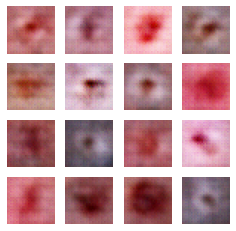

Time Step: 1, Epoch: 24
Discriminator Loss: 1.2134435176849365, Generator Loss: 0.704220175743103

Time Step: 2, Epoch: 24
Discriminator Loss: 1.1926960945129395, Generator Loss: 1.1650503873825073

Time Step: 3, Epoch: 24
Discriminator Loss: 1.3162180185317993, Generator Loss: 0.5450197458267212

Time Step: 4, Epoch: 24
Discriminator Loss: 1.379434585571289, Generator Loss: 1.4975982904434204

Time Step: 5, Epoch: 24
Discriminator Loss: 1.4523581266403198, Generator Loss: 0.36466848850250244

Time Step: 6, Epoch: 24
Discriminator Loss: 1.4203459024429321, Generator Loss: 1.6210026741027832

Time Step: 7, Epoch: 24
Discriminator Loss: 1.3688719272613525, Generator Loss: 0.45961350202560425

Time Step: 8, Epoch: 24
Discriminator Loss: 1.2124913930892944, Generator Loss: 1.0734940767288208

Time Step: 9, Epoch: 24
Discriminator Loss: 1.129575490951538, Generator Loss: 0.6654993891716003

Time Step: 10, Epoch: 24
Discriminator Loss: 1.217950463294983, Generator Loss: 1.0834444761276245

T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.2074193954467773, Generator Loss: 0.5577963590621948



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


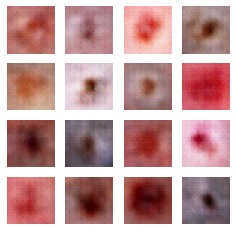

Time Step: 1, Epoch: 25
Discriminator Loss: 1.235469102859497, Generator Loss: 1.4199986457824707

Time Step: 2, Epoch: 25
Discriminator Loss: 1.3958160877227783, Generator Loss: 0.45392346382141113

Time Step: 3, Epoch: 25
Discriminator Loss: 1.2728577852249146, Generator Loss: 1.5010603666305542

Time Step: 4, Epoch: 25
Discriminator Loss: 1.3484153747558594, Generator Loss: 0.48634791374206543

Time Step: 5, Epoch: 25
Discriminator Loss: 1.4362270832061768, Generator Loss: 1.6140228509902954

Time Step: 6, Epoch: 25
Discriminator Loss: 1.6597124338150024, Generator Loss: 0.28765642642974854

Time Step: 7, Epoch: 25
Discriminator Loss: 1.4620705842971802, Generator Loss: 1.6229766607284546

Time Step: 8, Epoch: 25
Discriminator Loss: 1.277235746383667, Generator Loss: 0.5344812870025635

Time Step: 9, Epoch: 25
Discriminator Loss: 1.1565126180648804, Generator Loss: 1.093550682067871

Time Step: 10, Epoch: 25
Discriminator Loss: 1.2010725736618042, Generator Loss: 0.6803730130195618


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.1542869806289673, Generator Loss: 0.8902708888053894



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


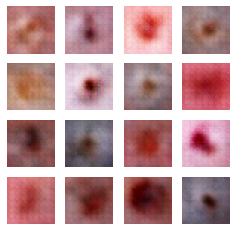

Time Step: 1, Epoch: 26
Discriminator Loss: 1.2684435844421387, Generator Loss: 0.8630452156066895

Time Step: 2, Epoch: 26
Discriminator Loss: 1.190901279449463, Generator Loss: 0.7628002166748047

Time Step: 3, Epoch: 26
Discriminator Loss: 1.0831880569458008, Generator Loss: 0.9877404570579529

Time Step: 4, Epoch: 26
Discriminator Loss: 1.066763162612915, Generator Loss: 0.8362901210784912

Time Step: 5, Epoch: 26
Discriminator Loss: 1.088122844696045, Generator Loss: 1.0949912071228027

Time Step: 6, Epoch: 26
Discriminator Loss: 1.2956665754318237, Generator Loss: 0.5328995585441589

Time Step: 7, Epoch: 26
Discriminator Loss: 1.4150042533874512, Generator Loss: 1.4943656921386719

Time Step: 8, Epoch: 26
Discriminator Loss: 1.3868860006332397, Generator Loss: 0.4114786684513092

Time Step: 9, Epoch: 26
Discriminator Loss: 1.2486622333526611, Generator Loss: 1.5353503227233887

Time Step: 10, Epoch: 26
Discriminator Loss: 1.3161919116973877, Generator Loss: 0.46668532490730286

T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


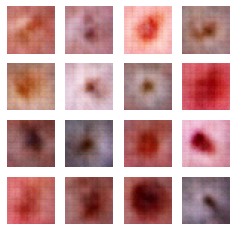

Time Step: 1, Epoch: 27
Discriminator Loss: 1.249184250831604, Generator Loss: 1.1983067989349365

Time Step: 2, Epoch: 27
Discriminator Loss: 1.2160909175872803, Generator Loss: 0.6183710098266602

Time Step: 3, Epoch: 27
Discriminator Loss: 1.1495022773742676, Generator Loss: 1.2733685970306396

Time Step: 4, Epoch: 27
Discriminator Loss: 1.1799612045288086, Generator Loss: 0.6002217531204224

Time Step: 5, Epoch: 27
Discriminator Loss: 1.1555168628692627, Generator Loss: 1.4083232879638672

Time Step: 6, Epoch: 27
Discriminator Loss: 1.2670913934707642, Generator Loss: 0.5260882377624512

Time Step: 7, Epoch: 27
Discriminator Loss: 1.2462382316589355, Generator Loss: 1.4648261070251465

Time Step: 8, Epoch: 27
Discriminator Loss: 1.3114324808120728, Generator Loss: 0.5005207061767578

Time Step: 9, Epoch: 27
Discriminator Loss: 1.1379390954971313, Generator Loss: 1.5351080894470215

Time Step: 10, Epoch: 27
Discriminator Loss: 1.1615279912948608, Generator Loss: 0.5737389326095581



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.291191577911377, Generator Loss: 0.5247792601585388



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


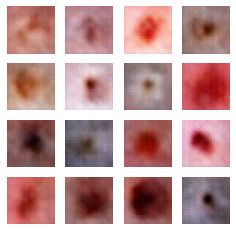

Time Step: 1, Epoch: 28
Discriminator Loss: 1.2179417610168457, Generator Loss: 1.6477669477462769

Time Step: 2, Epoch: 28
Discriminator Loss: 1.3955833911895752, Generator Loss: 0.43105843663215637

Time Step: 3, Epoch: 28
Discriminator Loss: 1.2244069576263428, Generator Loss: 1.5121078491210938

Time Step: 4, Epoch: 28
Discriminator Loss: 1.2734882831573486, Generator Loss: 0.5043826103210449

Time Step: 5, Epoch: 28
Discriminator Loss: 1.2420883178710938, Generator Loss: 1.3452768325805664

Time Step: 6, Epoch: 28
Discriminator Loss: 1.1365909576416016, Generator Loss: 0.6350583434104919

Time Step: 7, Epoch: 28
Discriminator Loss: 1.0953341722488403, Generator Loss: 1.2680330276489258

Time Step: 8, Epoch: 28
Discriminator Loss: 1.3263241052627563, Generator Loss: 0.4855363368988037

Time Step: 9, Epoch: 28
Discriminator Loss: 1.3728581666946411, Generator Loss: 1.6807143688201904

Time Step: 10, Epoch: 28
Discriminator Loss: 1.493788480758667, Generator Loss: 0.38141316175460815

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.2366094589233398, Generator Loss: 0.5182511806488037



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


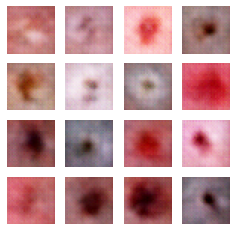

Time Step: 1, Epoch: 29
Discriminator Loss: 1.4696133136749268, Generator Loss: 1.9110143184661865

Time Step: 2, Epoch: 29
Discriminator Loss: 1.65677011013031, Generator Loss: 0.28697720170021057

Time Step: 3, Epoch: 29
Discriminator Loss: 1.6281421184539795, Generator Loss: 1.7774274349212646

Time Step: 4, Epoch: 29
Discriminator Loss: 1.5458345413208008, Generator Loss: 0.32002416253089905

Time Step: 5, Epoch: 29
Discriminator Loss: 1.4874444007873535, Generator Loss: 1.719435691833496

Time Step: 6, Epoch: 29
Discriminator Loss: 1.4715591669082642, Generator Loss: 0.40889692306518555

Time Step: 7, Epoch: 29
Discriminator Loss: 1.149868130683899, Generator Loss: 1.1336121559143066

Time Step: 8, Epoch: 29
Discriminator Loss: 1.2104378938674927, Generator Loss: 0.7823273539543152

Time Step: 9, Epoch: 29
Discriminator Loss: 1.1950185298919678, Generator Loss: 0.8896876573562622

Time Step: 10, Epoch: 29
Discriminator Loss: 1.191478967666626, Generator Loss: 0.8382012844085693

T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.3729820251464844, Generator Loss: 0.5338538289070129



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


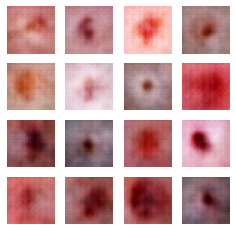

Time Step: 1, Epoch: 30
Discriminator Loss: 1.2736308574676514, Generator Loss: 1.223724126815796

Time Step: 2, Epoch: 30
Discriminator Loss: 1.2874188423156738, Generator Loss: 0.5481642484664917

Time Step: 3, Epoch: 30
Discriminator Loss: 1.2003059387207031, Generator Loss: 1.4147613048553467

Time Step: 4, Epoch: 30
Discriminator Loss: 1.2430421113967896, Generator Loss: 0.5596365928649902

Time Step: 5, Epoch: 30
Discriminator Loss: 1.2525954246520996, Generator Loss: 1.2780630588531494

Time Step: 6, Epoch: 30
Discriminator Loss: 1.2650752067565918, Generator Loss: 0.5138892531394958

Time Step: 7, Epoch: 30
Discriminator Loss: 1.284172773361206, Generator Loss: 1.588531732559204

Time Step: 8, Epoch: 30
Discriminator Loss: 1.3698488473892212, Generator Loss: 0.44512873888015747

Time Step: 9, Epoch: 30
Discriminator Loss: 1.116644263267517, Generator Loss: 1.360479712486267

Time Step: 10, Epoch: 30
Discriminator Loss: 1.2613565921783447, Generator Loss: 0.5471282005310059

Tim

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.8911793231964111, Generator Loss: 0.21269196271896362



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


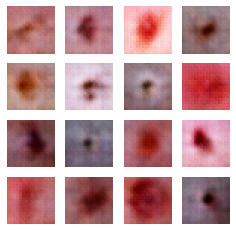

Time Step: 1, Epoch: 31
Discriminator Loss: 1.3571594953536987, Generator Loss: 1.7594964504241943

Time Step: 2, Epoch: 31
Discriminator Loss: 1.397292971611023, Generator Loss: 0.48559296131134033

Time Step: 3, Epoch: 31
Discriminator Loss: 1.1279276609420776, Generator Loss: 1.1293390989303589

Time Step: 4, Epoch: 31
Discriminator Loss: 1.163170576095581, Generator Loss: 0.7004416584968567

Time Step: 5, Epoch: 31
Discriminator Loss: 1.1328809261322021, Generator Loss: 1.0959141254425049

Time Step: 6, Epoch: 31
Discriminator Loss: 1.276082992553711, Generator Loss: 0.6889708638191223

Time Step: 7, Epoch: 31
Discriminator Loss: 1.2459321022033691, Generator Loss: 1.0203313827514648

Time Step: 8, Epoch: 31
Discriminator Loss: 1.2431334257125854, Generator Loss: 0.6722681522369385

Time Step: 9, Epoch: 31
Discriminator Loss: 1.1767659187316895, Generator Loss: 1.207357406616211

Time Step: 10, Epoch: 31
Discriminator Loss: 1.2339063882827759, Generator Loss: 0.5812534093856812

Ti

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.1812634468078613, Generator Loss: 0.6884933710098267



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


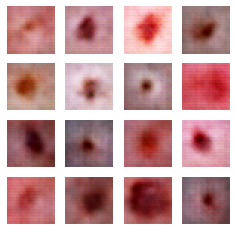

Time Step: 1, Epoch: 32
Discriminator Loss: 1.1697957515716553, Generator Loss: 0.9864152073860168

Time Step: 2, Epoch: 32
Discriminator Loss: 1.307146668434143, Generator Loss: 0.6738889217376709

Time Step: 3, Epoch: 32
Discriminator Loss: 1.2782472372055054, Generator Loss: 1.1535158157348633

Time Step: 4, Epoch: 32
Discriminator Loss: 1.3181051015853882, Generator Loss: 0.5720053315162659

Time Step: 5, Epoch: 32
Discriminator Loss: 1.3121095895767212, Generator Loss: 1.3786486387252808

Time Step: 6, Epoch: 32
Discriminator Loss: 1.3613033294677734, Generator Loss: 0.44783711433410645

Time Step: 7, Epoch: 32
Discriminator Loss: 1.3431836366653442, Generator Loss: 1.569638729095459

Time Step: 8, Epoch: 32
Discriminator Loss: 1.3410178422927856, Generator Loss: 0.46324968338012695

Time Step: 9, Epoch: 32
Discriminator Loss: 1.3704031705856323, Generator Loss: 1.4298577308654785

Time Step: 10, Epoch: 32
Discriminator Loss: 1.3846186399459839, Generator Loss: 0.401030570268631



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.4207749366760254, Generator Loss: 0.4335009455680847



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


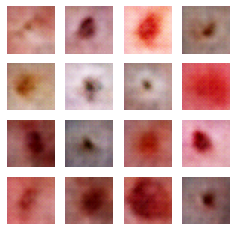

Time Step: 1, Epoch: 33
Discriminator Loss: 1.4168074131011963, Generator Loss: 1.4729242324829102

Time Step: 2, Epoch: 33
Discriminator Loss: 1.6237514019012451, Generator Loss: 0.35410043597221375

Time Step: 3, Epoch: 33
Discriminator Loss: 1.272927165031433, Generator Loss: 1.306674838066101

Time Step: 4, Epoch: 33
Discriminator Loss: 1.1949325799942017, Generator Loss: 0.6578512787818909

Time Step: 5, Epoch: 33
Discriminator Loss: 1.15462327003479, Generator Loss: 1.2087808847427368

Time Step: 6, Epoch: 33
Discriminator Loss: 1.445030927658081, Generator Loss: 0.4351051151752472

Time Step: 7, Epoch: 33
Discriminator Loss: 1.4080743789672852, Generator Loss: 1.720818042755127

Time Step: 8, Epoch: 33
Discriminator Loss: 1.4520808458328247, Generator Loss: 0.3889440894126892

Time Step: 9, Epoch: 33
Discriminator Loss: 1.3667702674865723, Generator Loss: 1.4838706254959106

Time Step: 10, Epoch: 33
Discriminator Loss: 1.3448320627212524, Generator Loss: 0.44066059589385986

Tim

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.3819688558578491, Generator Loss: 0.4358178973197937



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


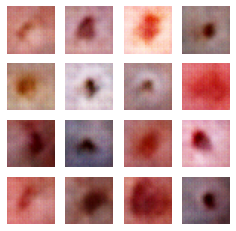

Time Step: 1, Epoch: 34
Discriminator Loss: 1.3047733306884766, Generator Loss: 1.5528936386108398

Time Step: 2, Epoch: 34
Discriminator Loss: 1.300656795501709, Generator Loss: 0.46907564997673035

Time Step: 3, Epoch: 34
Discriminator Loss: 1.1570063829421997, Generator Loss: 1.234753131866455

Time Step: 4, Epoch: 34
Discriminator Loss: 1.0948612689971924, Generator Loss: 0.7326412796974182

Time Step: 5, Epoch: 34
Discriminator Loss: 1.161840558052063, Generator Loss: 1.0459976196289062

Time Step: 6, Epoch: 34
Discriminator Loss: 1.2924975156784058, Generator Loss: 0.6539278626441956

Time Step: 7, Epoch: 34
Discriminator Loss: 1.270461916923523, Generator Loss: 1.1909260749816895

Time Step: 8, Epoch: 34
Discriminator Loss: 1.3464323282241821, Generator Loss: 0.5034843683242798

Time Step: 9, Epoch: 34
Discriminator Loss: 1.3143949508666992, Generator Loss: 1.4528632164001465

Time Step: 10, Epoch: 34
Discriminator Loss: 1.4650685787200928, Generator Loss: 0.3887210488319397

Ti

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.3414552211761475, Generator Loss: 0.5307555198669434



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


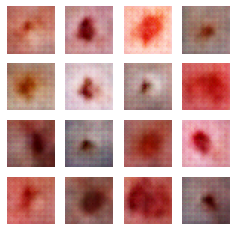

Time Step: 1, Epoch: 35
Discriminator Loss: 1.3842666149139404, Generator Loss: 1.5485647916793823

Time Step: 2, Epoch: 35
Discriminator Loss: 1.685623049736023, Generator Loss: 0.27278468012809753

Time Step: 3, Epoch: 35
Discriminator Loss: 1.502625584602356, Generator Loss: 2.079528331756592

Time Step: 4, Epoch: 35
Discriminator Loss: 1.5031465291976929, Generator Loss: 0.36936789751052856

Time Step: 5, Epoch: 35
Discriminator Loss: 1.1305012702941895, Generator Loss: 1.238503098487854

Time Step: 6, Epoch: 35
Discriminator Loss: 1.1990044116973877, Generator Loss: 0.6785800457000732

Time Step: 7, Epoch: 35
Discriminator Loss: 1.2095777988433838, Generator Loss: 0.8973706960678101

Time Step: 8, Epoch: 35
Discriminator Loss: 1.2041412591934204, Generator Loss: 0.8368412256240845

Time Step: 9, Epoch: 35
Discriminator Loss: 1.1735172271728516, Generator Loss: 0.7504117488861084

Time Step: 10, Epoch: 35
Discriminator Loss: 1.2752766609191895, Generator Loss: 0.9061259627342224

T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.3622363805770874, Generator Loss: 0.5209730863571167



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


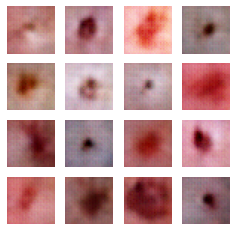

Time Step: 1, Epoch: 36
Discriminator Loss: 1.4184321165084839, Generator Loss: 1.564723253250122

Time Step: 2, Epoch: 36
Discriminator Loss: 1.5005230903625488, Generator Loss: 0.3764037489891052

Time Step: 3, Epoch: 36
Discriminator Loss: 1.131882667541504, Generator Loss: 1.3348290920257568

Time Step: 4, Epoch: 36
Discriminator Loss: 1.250046968460083, Generator Loss: 0.6439819931983948

Time Step: 5, Epoch: 36
Discriminator Loss: 1.1931452751159668, Generator Loss: 0.9642675518989563

Time Step: 6, Epoch: 36
Discriminator Loss: 1.2508947849273682, Generator Loss: 0.848720908164978

Time Step: 7, Epoch: 36
Discriminator Loss: 1.2158304452896118, Generator Loss: 0.8915433883666992

Time Step: 8, Epoch: 36
Discriminator Loss: 1.2888541221618652, Generator Loss: 0.8119857311248779

Time Step: 9, Epoch: 36
Discriminator Loss: 1.1652472019195557, Generator Loss: 0.823684811592102

Time Step: 10, Epoch: 36
Discriminator Loss: 1.1840567588806152, Generator Loss: 0.9593337774276733

Time

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.3470375537872314, Generator Loss: 1.554654598236084



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


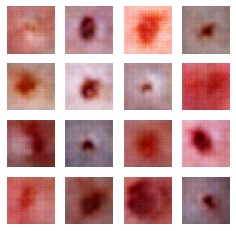

Time Step: 1, Epoch: 37
Discriminator Loss: 1.4023449420928955, Generator Loss: 0.43406593799591064

Time Step: 2, Epoch: 37
Discriminator Loss: 1.2778270244598389, Generator Loss: 1.0483968257904053

Time Step: 3, Epoch: 37
Discriminator Loss: 1.2526577711105347, Generator Loss: 0.6978362798690796

Time Step: 4, Epoch: 37
Discriminator Loss: 1.2315926551818848, Generator Loss: 0.8790565729141235

Time Step: 5, Epoch: 37
Discriminator Loss: 1.176919937133789, Generator Loss: 0.8931386470794678

Time Step: 6, Epoch: 37
Discriminator Loss: 1.176893711090088, Generator Loss: 0.8097941875457764

Time Step: 7, Epoch: 37
Discriminator Loss: 1.1839466094970703, Generator Loss: 0.941948652267456

Time Step: 8, Epoch: 37
Discriminator Loss: 1.2640434503555298, Generator Loss: 0.650404691696167

Time Step: 9, Epoch: 37
Discriminator Loss: 1.2584731578826904, Generator Loss: 1.111997365951538

Time Step: 10, Epoch: 37
Discriminator Loss: 1.295299768447876, Generator Loss: 0.4953840672969818

Time

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.6478474140167236, Generator Loss: 0.2863413095474243



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


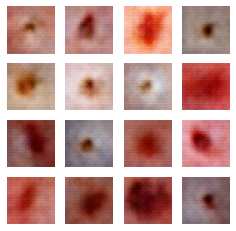

Time Step: 1, Epoch: 38
Discriminator Loss: 1.2757773399353027, Generator Loss: 1.2025172710418701

Time Step: 2, Epoch: 38
Discriminator Loss: 1.3706774711608887, Generator Loss: 0.5991102457046509

Time Step: 3, Epoch: 38
Discriminator Loss: 1.3451869487762451, Generator Loss: 0.8181688785552979

Time Step: 4, Epoch: 38
Discriminator Loss: 1.2334578037261963, Generator Loss: 0.7967391014099121

Time Step: 5, Epoch: 38
Discriminator Loss: 1.2214239835739136, Generator Loss: 0.772789478302002

Time Step: 6, Epoch: 38
Discriminator Loss: 1.2486649751663208, Generator Loss: 0.9361138343811035

Time Step: 7, Epoch: 38
Discriminator Loss: 1.3121784925460815, Generator Loss: 0.6166592836380005

Time Step: 8, Epoch: 38
Discriminator Loss: 1.2194064855575562, Generator Loss: 1.1091375350952148

Time Step: 9, Epoch: 38
Discriminator Loss: 1.3646916151046753, Generator Loss: 0.49164390563964844

Time Step: 10, Epoch: 38
Discriminator Loss: 1.265488862991333, Generator Loss: 1.3546626567840576



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.8016142845153809, Generator Loss: 1.913834810256958



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


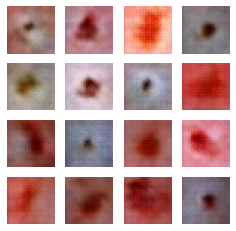

Time Step: 1, Epoch: 39
Discriminator Loss: 1.4729554653167725, Generator Loss: 0.3725256621837616

Time Step: 2, Epoch: 39
Discriminator Loss: 1.1553337574005127, Generator Loss: 0.8544495105743408

Time Step: 3, Epoch: 39
Discriminator Loss: 1.0870131254196167, Generator Loss: 1.057478666305542

Time Step: 4, Epoch: 39
Discriminator Loss: 1.1805155277252197, Generator Loss: 0.7131547331809998

Time Step: 5, Epoch: 39
Discriminator Loss: 1.1395974159240723, Generator Loss: 0.8972243666648865

Time Step: 6, Epoch: 39
Discriminator Loss: 1.2724865674972534, Generator Loss: 0.7490725517272949

Time Step: 7, Epoch: 39
Discriminator Loss: 1.3003621101379395, Generator Loss: 0.7654460668563843

Time Step: 8, Epoch: 39
Discriminator Loss: 1.2867200374603271, Generator Loss: 0.7807269096374512

Time Step: 9, Epoch: 39
Discriminator Loss: 1.2659306526184082, Generator Loss: 0.8109899759292603

Time Step: 10, Epoch: 39
Discriminator Loss: 1.33739173412323, Generator Loss: 0.7690253257751465

Ti

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.2952121496200562, Generator Loss: 1.3207679986953735



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


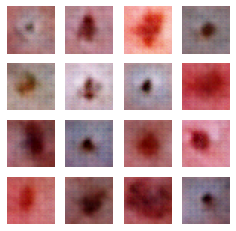

Time Step: 1, Epoch: 40
Discriminator Loss: 1.3388142585754395, Generator Loss: 0.5920122265815735

Time Step: 2, Epoch: 40
Discriminator Loss: 1.203665852546692, Generator Loss: 0.8549697399139404

Time Step: 3, Epoch: 40
Discriminator Loss: 1.1496152877807617, Generator Loss: 0.8636288046836853

Time Step: 4, Epoch: 40
Discriminator Loss: 1.1671762466430664, Generator Loss: 0.7884222865104675

Time Step: 5, Epoch: 40
Discriminator Loss: 1.2615238428115845, Generator Loss: 0.7869808673858643

Time Step: 6, Epoch: 40
Discriminator Loss: 1.2602680921554565, Generator Loss: 0.7878140211105347

Time Step: 7, Epoch: 40
Discriminator Loss: 1.2768436670303345, Generator Loss: 0.8091956973075867

Time Step: 8, Epoch: 40
Discriminator Loss: 1.3141887187957764, Generator Loss: 0.7219496369361877

Time Step: 9, Epoch: 40
Discriminator Loss: 1.2413653135299683, Generator Loss: 0.816939115524292

Time Step: 10, Epoch: 40
Discriminator Loss: 1.1809940338134766, Generator Loss: 0.8584569692611694

T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.4297125339508057, Generator Loss: 0.4100976586341858



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


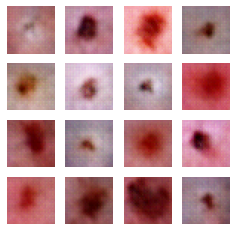

Time Step: 1, Epoch: 41
Discriminator Loss: 1.3690826892852783, Generator Loss: 1.4283307790756226

Time Step: 2, Epoch: 41
Discriminator Loss: 1.5251874923706055, Generator Loss: 0.37225377559661865

Time Step: 3, Epoch: 41
Discriminator Loss: 1.3094429969787598, Generator Loss: 1.3562129735946655

Time Step: 4, Epoch: 41
Discriminator Loss: 1.3246389627456665, Generator Loss: 0.5334571599960327

Time Step: 5, Epoch: 41
Discriminator Loss: 1.2355210781097412, Generator Loss: 1.0169470310211182

Time Step: 6, Epoch: 41
Discriminator Loss: 1.2889723777770996, Generator Loss: 0.6682549715042114

Time Step: 7, Epoch: 41
Discriminator Loss: 1.2580209970474243, Generator Loss: 0.9426161050796509

Time Step: 8, Epoch: 41
Discriminator Loss: 1.3092591762542725, Generator Loss: 0.6186620593070984

Time Step: 9, Epoch: 41
Discriminator Loss: 1.2513726949691772, Generator Loss: 1.0546119213104248

Time Step: 10, Epoch: 41
Discriminator Loss: 1.4318649768829346, Generator Loss: 0.4866289496421814

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.3680895566940308, Generator Loss: 0.5855324268341064



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


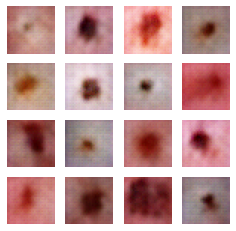

Time Step: 1, Epoch: 42
Discriminator Loss: 1.2762987613677979, Generator Loss: 1.0595712661743164

Time Step: 2, Epoch: 42
Discriminator Loss: 1.207902193069458, Generator Loss: 0.740365743637085

Time Step: 3, Epoch: 42
Discriminator Loss: 1.1764628887176514, Generator Loss: 0.8995181322097778

Time Step: 4, Epoch: 42
Discriminator Loss: 1.2600899934768677, Generator Loss: 0.6770386695861816

Time Step: 5, Epoch: 42
Discriminator Loss: 1.20638108253479, Generator Loss: 1.014148473739624

Time Step: 6, Epoch: 42
Discriminator Loss: 1.5020662546157837, Generator Loss: 0.43269872665405273

Time Step: 7, Epoch: 42
Discriminator Loss: 1.6714951992034912, Generator Loss: 1.6589374542236328

Time Step: 8, Epoch: 42
Discriminator Loss: 1.7077747583389282, Generator Loss: 0.2578325867652893

Time Step: 9, Epoch: 42
Discriminator Loss: 1.3123276233673096, Generator Loss: 1.4629347324371338

Time Step: 10, Epoch: 42
Discriminator Loss: 1.3328511714935303, Generator Loss: 0.4665466547012329

Tim

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.5369155406951904, Generator Loss: 0.3829558491706848



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


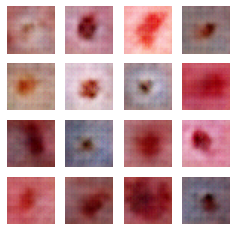

Time Step: 1, Epoch: 43
Discriminator Loss: 1.322838306427002, Generator Loss: 1.206465244293213

Time Step: 2, Epoch: 43
Discriminator Loss: 1.387606143951416, Generator Loss: 0.45654499530792236

Time Step: 3, Epoch: 43
Discriminator Loss: 1.305892825126648, Generator Loss: 1.1116912364959717

Time Step: 4, Epoch: 43
Discriminator Loss: 1.3395593166351318, Generator Loss: 0.5621500015258789

Time Step: 5, Epoch: 43
Discriminator Loss: 1.328748106956482, Generator Loss: 1.1056976318359375

Time Step: 6, Epoch: 43
Discriminator Loss: 1.4028973579406738, Generator Loss: 0.4955050051212311

Time Step: 7, Epoch: 43
Discriminator Loss: 1.4392285346984863, Generator Loss: 1.2540886402130127

Time Step: 8, Epoch: 43
Discriminator Loss: 1.4309463500976562, Generator Loss: 0.4432488679885864

Time Step: 9, Epoch: 43
Discriminator Loss: 1.2314882278442383, Generator Loss: 1.02235746383667

Time Step: 10, Epoch: 43
Discriminator Loss: 1.201387882232666, Generator Loss: 0.7201328873634338

Time S

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.2897825241088867, Generator Loss: 1.0483464002609253



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

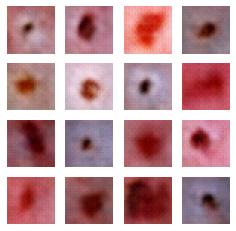

Time Step: 1, Epoch: 44
Discriminator Loss: 1.3909947872161865, Generator Loss: 0.5326112508773804

Time Step: 2, Epoch: 44
Discriminator Loss: 1.2968086004257202, Generator Loss: 0.9830849170684814

Time Step: 3, Epoch: 44
Discriminator Loss: 1.3077952861785889, Generator Loss: 0.6680177450180054

Time Step: 4, Epoch: 44
Discriminator Loss: 1.2884256839752197, Generator Loss: 0.829635500907898

Time Step: 5, Epoch: 44
Discriminator Loss: 1.2669939994812012, Generator Loss: 0.6679269075393677

Time Step: 6, Epoch: 44
Discriminator Loss: 1.207198143005371, Generator Loss: 1.092542290687561

Time Step: 7, Epoch: 44
Discriminator Loss: 1.3888814449310303, Generator Loss: 0.4900616407394409

Time Step: 8, Epoch: 44
Discriminator Loss: 1.2581920623779297, Generator Loss: 1.3330309391021729

Time Step: 9, Epoch: 44
Discriminator Loss: 1.276978850364685, Generator Loss: 0.5741392374038696

Time Step: 10, Epoch: 44
Discriminator Loss: 1.1772719621658325, Generator Loss: 1.0075045824050903

Tim

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.3629231452941895, Generator Loss: 1.0675480365753174



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


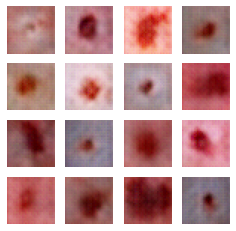

Time Step: 1, Epoch: 45
Discriminator Loss: 1.3231635093688965, Generator Loss: 0.5732946991920471

Time Step: 2, Epoch: 45
Discriminator Loss: 1.3167093992233276, Generator Loss: 1.0958250761032104

Time Step: 3, Epoch: 45
Discriminator Loss: 1.3788905143737793, Generator Loss: 0.5025779008865356

Time Step: 4, Epoch: 45
Discriminator Loss: 1.248611330986023, Generator Loss: 1.0683664083480835

Time Step: 5, Epoch: 45
Discriminator Loss: 1.3665739297866821, Generator Loss: 0.5578843951225281

Time Step: 6, Epoch: 45
Discriminator Loss: 1.2810688018798828, Generator Loss: 0.8803348541259766

Time Step: 7, Epoch: 45
Discriminator Loss: 1.337678074836731, Generator Loss: 0.6115439534187317

Time Step: 8, Epoch: 45
Discriminator Loss: 1.2873051166534424, Generator Loss: 0.8537645936012268

Time Step: 9, Epoch: 45
Discriminator Loss: 1.2779659032821655, Generator Loss: 0.6680220365524292

Time Step: 10, Epoch: 45
Discriminator Loss: 1.2248307466506958, Generator Loss: 0.9584518671035767

T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.390638828277588, Generator Loss: 1.0861834287643433



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


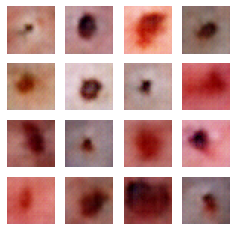

Time Step: 1, Epoch: 46
Discriminator Loss: 1.3460530042648315, Generator Loss: 0.5675079822540283

Time Step: 2, Epoch: 46
Discriminator Loss: 1.2851035594940186, Generator Loss: 0.9249721765518188

Time Step: 3, Epoch: 46
Discriminator Loss: 1.2392518520355225, Generator Loss: 0.7105910778045654

Time Step: 4, Epoch: 46
Discriminator Loss: 1.2335844039916992, Generator Loss: 0.95167076587677

Time Step: 5, Epoch: 46
Discriminator Loss: 1.3509957790374756, Generator Loss: 0.5571268796920776

Time Step: 6, Epoch: 46
Discriminator Loss: 1.361140251159668, Generator Loss: 1.152387261390686

Time Step: 7, Epoch: 46
Discriminator Loss: 1.5314639806747437, Generator Loss: 0.42572125792503357

Time Step: 8, Epoch: 46
Discriminator Loss: 1.3695487976074219, Generator Loss: 1.3890236616134644

Time Step: 9, Epoch: 46
Discriminator Loss: 1.5978986024856567, Generator Loss: 0.3281468451023102

Time Step: 10, Epoch: 46
Discriminator Loss: 1.3614294528961182, Generator Loss: 1.181433916091919

Tim

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.2911020517349243, Generator Loss: 1.1295074224472046



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


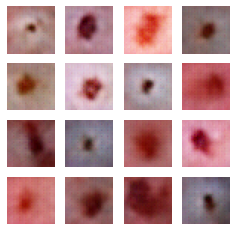

Time Step: 1, Epoch: 47
Discriminator Loss: 1.2880749702453613, Generator Loss: 0.5480430126190186

Time Step: 2, Epoch: 47
Discriminator Loss: 1.205240249633789, Generator Loss: 1.2137205600738525

Time Step: 3, Epoch: 47
Discriminator Loss: 1.4113072156906128, Generator Loss: 0.4637599289417267

Time Step: 4, Epoch: 47
Discriminator Loss: 1.3007946014404297, Generator Loss: 1.0922176837921143

Time Step: 5, Epoch: 47
Discriminator Loss: 1.3924702405929565, Generator Loss: 0.5265238285064697

Time Step: 6, Epoch: 47
Discriminator Loss: 1.3453515768051147, Generator Loss: 1.033005952835083

Time Step: 7, Epoch: 47
Discriminator Loss: 1.3512862920761108, Generator Loss: 0.5661667585372925

Time Step: 8, Epoch: 47
Discriminator Loss: 1.3606476783752441, Generator Loss: 1.1362488269805908

Time Step: 9, Epoch: 47
Discriminator Loss: 1.4973530769348145, Generator Loss: 0.4257728159427643

Time Step: 10, Epoch: 47
Discriminator Loss: 1.2728381156921387, Generator Loss: 1.2271097898483276

T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.3878865242004395, Generator Loss: 0.4679271876811981



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


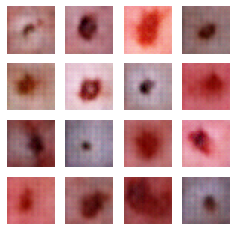

Time Step: 1, Epoch: 48
Discriminator Loss: 1.238900899887085, Generator Loss: 1.1000993251800537

Time Step: 2, Epoch: 48
Discriminator Loss: 1.2462847232818604, Generator Loss: 0.6357764005661011

Time Step: 3, Epoch: 48
Discriminator Loss: 1.2558107376098633, Generator Loss: 0.8058109283447266

Time Step: 4, Epoch: 48
Discriminator Loss: 1.2412290573120117, Generator Loss: 0.7986799478530884

Time Step: 5, Epoch: 48
Discriminator Loss: 1.2302627563476562, Generator Loss: 0.7870758175849915

Time Step: 6, Epoch: 48
Discriminator Loss: 1.2873048782348633, Generator Loss: 0.6748988032341003

Time Step: 7, Epoch: 48
Discriminator Loss: 1.3714454174041748, Generator Loss: 0.9855707883834839

Time Step: 8, Epoch: 48
Discriminator Loss: 1.4378823041915894, Generator Loss: 0.48352304100990295

Time Step: 9, Epoch: 48
Discriminator Loss: 1.4793877601623535, Generator Loss: 1.5742378234863281

Time Step: 10, Epoch: 48
Discriminator Loss: 1.6648271083831787, Generator Loss: 0.26499131321907043

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.2726953029632568, Generator Loss: 0.6985999345779419



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


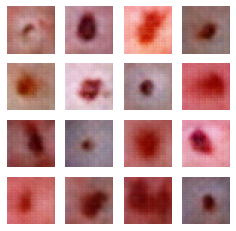

Time Step: 1, Epoch: 49
Discriminator Loss: 1.320234775543213, Generator Loss: 0.805486798286438

Time Step: 2, Epoch: 49
Discriminator Loss: 1.341387152671814, Generator Loss: 0.6041017174720764

Time Step: 3, Epoch: 49
Discriminator Loss: 1.374592900276184, Generator Loss: 0.9907166957855225

Time Step: 4, Epoch: 49
Discriminator Loss: 1.4287481307983398, Generator Loss: 0.4860070049762726

Time Step: 5, Epoch: 49
Discriminator Loss: 1.3948535919189453, Generator Loss: 1.202430248260498

Time Step: 6, Epoch: 49
Discriminator Loss: 1.3839740753173828, Generator Loss: 0.48048099875450134

Time Step: 7, Epoch: 49
Discriminator Loss: 1.2727893590927124, Generator Loss: 1.0516377687454224

Time Step: 8, Epoch: 49
Discriminator Loss: 1.4026678800582886, Generator Loss: 0.5318929553031921

Time Step: 9, Epoch: 49
Discriminator Loss: 1.313478708267212, Generator Loss: 0.8577191829681396

Time Step: 10, Epoch: 49
Discriminator Loss: 1.3750107288360596, Generator Loss: 0.673521876335144

Time 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.3822027444839478, Generator Loss: 0.8890184164047241



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


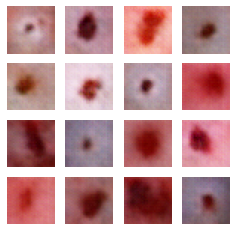

Time Step: 1, Epoch: 50
Discriminator Loss: 1.4129371643066406, Generator Loss: 0.5859127044677734

Time Step: 2, Epoch: 50
Discriminator Loss: 1.3890819549560547, Generator Loss: 0.831519365310669

Time Step: 3, Epoch: 50
Discriminator Loss: 1.4221746921539307, Generator Loss: 0.5622085928916931

Time Step: 4, Epoch: 50
Discriminator Loss: 1.3876941204071045, Generator Loss: 0.8726133108139038

Time Step: 5, Epoch: 50
Discriminator Loss: 1.2884900569915771, Generator Loss: 0.6371814012527466

Time Step: 6, Epoch: 50
Discriminator Loss: 1.3127765655517578, Generator Loss: 0.8960299491882324

Time Step: 7, Epoch: 50
Discriminator Loss: 1.2722458839416504, Generator Loss: 0.5739244222640991

Time Step: 8, Epoch: 50
Discriminator Loss: 1.247875452041626, Generator Loss: 1.13413405418396

Time Step: 9, Epoch: 50
Discriminator Loss: 1.3608875274658203, Generator Loss: 0.5086236000061035

Time Step: 10, Epoch: 50
Discriminator Loss: 1.280775785446167, Generator Loss: 0.9337220788002014

Time

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Discriminator Loss: 1.2488224506378174, Generator Loss: 0.8855422735214233



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


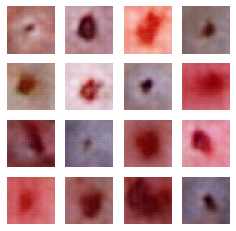

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


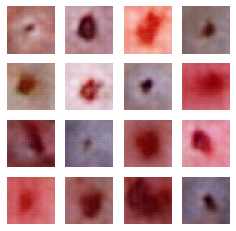

In [32]:
train_gan(real_imgs_datagen=unlabeled_datagen,total_epochs=GAN_epochs)

In [41]:
latest_checkpoint_path = tf.train.latest_checkpoint(os.path.join(root_dir , "Checkpoint"))

In [42]:
latest_checkpoint_path

'C:/Users/Mask/Desktop/AIML Projects/Semi -Supervised GANS for Melanoma Detection/MelanomaDetection\\Checkpoint\\ckpt-10'

In [43]:
GAN_checkpoint.restore(latest_checkpoint_path)

In [44]:
def generate_and_save_images(generator_model,test_input):

  generated_sample_images = generator_model(test_input,training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(generated_sample_images[i,:,:,:])
    plt.axis("off")

  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


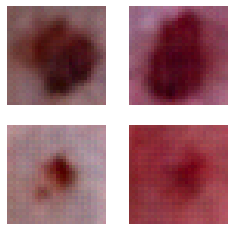

In [45]:
generate_and_save_images(generator_model=G,test_input=constant_noise)

In [48]:
unlbld_imgs_base_path = os.path.join(root_dir ,"unlabeled")

In [49]:
from random import randint

In [50]:
imgs_names_list = os.listdir(unlbld_imgs_base_path)

In [51]:
total_imgs = len(imgs_names_list)

In [52]:
single_img = plt.imread(os.path.join(unlbld_imgs_base_path,imgs_names_list[randint(0,total_imgs-1)]))

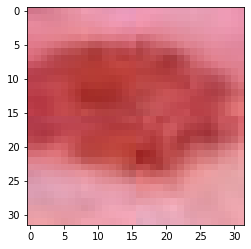

In [53]:
plt.imshow(single_img)

In [64]:
single_fake_img = G(tf.random.normal(shape=(1,100)))
single_fake_img.shape

TensorShape([1, 32, 32, 3])

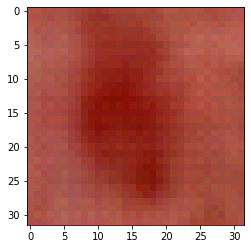

In [66]:
plt.imshow(single_fake_img[0,:,:,:])

In [67]:
def discriminator_base():

  input_to_cls = Input(shape=(32,32,3))

  disc_base = Sequential(name="disc_base")
  disc_base.add(input_to_cls)

  for layer in D.layers[0:10]:
    disc_base.add(layer)

  return disc_base

In [68]:
def unsupervised_classifier():

  disc_base = discriminator_base()

  disc_base.add(Dense(units=1,activation="sigmoid"))

  return disc_base

In [69]:
def supervised_classifier():

  disc_base = discriminator_base()

  disc_base.add(Dense(units=1,activation="sigmoid"))

  return disc_base

In [70]:
unsupervised_cls = unsupervised_classifier()
supervised_cls = supervised_classifier()

In [71]:
unsupervised_cls_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0001,beta_1=0.1)
supervised_cls_optimizer = keras.optimizers.adam_v2.Adam(learning_rate=0.0001,beta_1=0.1)

In [72]:
supervised_cls_train_acc_metric = tf.keras.metrics.BinaryAccuracy()
supervised_cls_cv_acc_metric = tf.keras.metrics.BinaryAccuracy()

In [73]:
def unsupervised_cls_loss(real_imgs_preds,fake_imgs_preds):

  real_imgs_labels = tf.ones_like(real_imgs_preds)
  fake_imgs_labels = tf.zeros_like(fake_imgs_preds)

  real_imgs_loss = bce_loss(y_true=real_imgs_labels,y_pred=real_imgs_preds)
  fake_imgs_loss = bce_loss(y_true=fake_imgs_labels,y_pred=fake_imgs_preds)

  total_loss = real_imgs_loss + fake_imgs_loss

  return total_loss

In [74]:
def supervised_cls_loss(imgs_labels,imgs_preds):

  imgs_labels = imgs_labels.reshape(imgs_labels.shape[0],1)

  return bce_loss(y_true=imgs_labels,y_pred=imgs_preds)

In [75]:
@tf.function
def ssl_training_step(labeled_images,unlabeled_images):

  G.trainable = False
  unsupervised_cls.trainable = True
  supervised_cls.trainable = True

  with tf.GradientTape() as supervised_cls_tape, tf.GradientTape() as unsupervised_cls_tape, tf.GradientTape() as gen_tape:

    labeled_imgs_preds = supervised_cls(labeled_images[0],training=True)
    
    supervised_loss = supervised_cls_loss(imgs_labels=labeled_images[1],imgs_preds=labeled_imgs_preds)

    gradients_of_supervised_cls = supervised_cls_tape.gradient(supervised_loss,supervised_cls.trainable_variables)
    supervised_cls_optimizer.apply_gradients(zip(gradients_of_supervised_cls,supervised_cls.trainable_variables))

    noise = tf.random.normal(shape=(batch_size,noise_shape))
    generated_images = G(noise,training=False)

    real_imgs_preds = unsupervised_cls(unlabeled_images,training=True)
    fake_imgs_preds = unsupervised_cls(generated_images,training=True)

    unsupervised_loss = unsupervised_cls_loss(real_imgs_preds,fake_imgs_preds)

    gradients_of_unsupervised_cls = unsupervised_cls_tape.gradient(unsupervised_loss,unsupervised_cls.trainable_variables)
    unsupervised_cls_optimizer.apply_gradients(zip(gradients_of_unsupervised_cls,unsupervised_cls.trainable_variables))

    supervised_cls.trainable = False
    unsupervised_cls.trainable = False

  return supervised_loss,labeled_imgs_preds

In [76]:
cls_checkpoint_dir = os.path.join(root_dir , "Cls Training Checkpoint")
checkpoint_prefix = os.path.join(cls_checkpoint_dir,"ckpt")
cls_checkpoint = tf.train.Checkpoint(optimizer=[supervised_cls_optimizer,unsupervised_cls_optimizer],
                                     model=[supervised_cls,unsupervised_cls])

In [82]:
# mkdir_Beneign = os.mkdir(os.path.join(root_dir,"test/Beneign"))
# mkdir_malignant = os.mkdir(os.path.join(root_dir,"test/Malignant"))

In [84]:
import shutil as s

In [85]:

# def segregating_labeled_in_Benign_and_Malignant(path):
#     for img in os.listdir(path):
#         if img[-5] =="0":
#             s.move(os.path.join(path,img),os.path.join(path,"Beneign"))
#         else:
#             s.move(os.path.join(path,img),os.path.join(path,"Malignant"))

# segregating_labeled_in_Benign_and_Malignant(os.path.join(root_dir,"test"))

In [77]:
cls_epochs = 50

In [86]:
cv_data_gen = ImageDataGenerator()

In [88]:
cv_datagen = cv_data_gen.flow_from_directory(directory=os.path.join(root_dir , "test"),
                                             target_size=(32,32),
                                             classes=os.listdir(os.path.join(root_dir , "test")),
                                             class_mode="binary",batch_size=150)

Found 600 images belonging to 2 classes.


In [80]:
labeled_data_gen = ImageDataGenerator(rotation_range=90,brightness_range=(0.5,1),horizontal_flip=True,vertical_flip=True,rescale=1.0/255.0)

In [89]:
labeled_datagen = labeled_data_gen.flow_from_directory(directory=os.path.join(root_dir , "labeled"),
                                                       target_size=(32,32),
                                                       classes=os.listdir(os.path.join(root_dir , "labeled")),
                                                       class_mode="binary",batch_size=7)

Found 200 images belonging to 2 classes.


In [92]:
def train_ssl_classifier(labeled_imgs_datagen,unlabeled_imgs_datagen,cv_imgs_datagen,total_epochs):

  for epoch in range(total_epochs):

    time_step = 1

    for labeled_images_batch, unlabeled_images_batch in zip(labeled_imgs_datagen,unlabeled_imgs_datagen):

      with tf.GradientTape() as supervised_cls_tape, tf.GradientTape() as unsupervised_cls_tape, tf.GradientTape() as gen_tape:

        G.trainable = False
        unsupervised_cls.trainable = True
        supervised_cls.trainable = True

        labeled_imgs_preds = supervised_cls(labeled_images_batch[0],training=True)
    
        supervised_loss = supervised_cls_loss(imgs_labels=labeled_images_batch[1],imgs_preds=labeled_imgs_preds)

        gradients_of_supervised_cls = supervised_cls_tape.gradient(supervised_loss,supervised_cls.trainable_variables)
        supervised_cls_optimizer.apply_gradients(zip(gradients_of_supervised_cls,supervised_cls.trainable_variables))

        noise = tf.random.normal(shape=(batch_size,noise_shape))
        generated_images = G(noise,training=False)

        real_imgs_preds = unsupervised_cls(unlabeled_images_batch[0],training=True)
        fake_imgs_preds = unsupervised_cls(generated_images,training=True)

        unsupervised_loss = unsupervised_cls_loss(real_imgs_preds,fake_imgs_preds)

        gradients_of_unsupervised_cls = unsupervised_cls_tape.gradient(unsupervised_loss,unsupervised_cls.trainable_variables)
        unsupervised_cls_optimizer.apply_gradients(zip(gradients_of_unsupervised_cls,unsupervised_cls.trainable_variables))

        supervised_cls.trainable = False
        unsupervised_cls.trainable = False

      if time_step > len(os.listdir(os.path.join(root_dir , "unlabeled")))//batch_size:
        break

      supervised_cls_train_acc_metric.update_state(labeled_images_batch[1],labeled_imgs_preds)
      print("Training Loss at Time Step {} of Epoch {} is {}".format(time_step,epoch+1,float(supervised_loss)))

      time_step = time_step + 1

    training_accuracy = supervised_cls_train_acc_metric.result()
    print("\nTraining Accuracy after Epoch {} is {}".format(epoch+1,float(training_accuracy)))

    supervised_cls_train_acc_metric.reset_states()

    cv_time_steps = 0

    for X_cv,Y_cv_labels in cv_imgs_datagen:

      if cv_time_steps > 300//150:
        break

      cv_time_steps = cv_time_steps + 1

      Y_cv_preds = supervised_cls(X_cv,training=False)
      supervised_cls_cv_acc_metric.update_state(Y_cv_labels,Y_cv_preds)

    cv_accuracy = supervised_cls_cv_acc_metric.result()
    print("Corss Validation Accuracy after Epoch {} is {}\n".format(epoch+1,float(cv_accuracy)))

    supervised_cls_cv_acc_metric.reset_states()

    cls_checkpoint.save(file_prefix=checkpoint_prefix)

In [93]:
train_ssl_classifier(labeled_imgs_datagen=labeled_datagen,unlabeled_imgs_datagen=unlabeled_datagen,
                     cv_imgs_datagen=cv_datagen,total_epochs=cls_epochs)

Training Loss at Time Step 1 of Epoch 1 is 0.7687515616416931
Training Loss at Time Step 2 of Epoch 1 is 0.619928240776062
Training Loss at Time Step 3 of Epoch 1 is 0.7852801084518433
Training Loss at Time Step 4 of Epoch 1 is 0.8432626724243164
Training Loss at Time Step 5 of Epoch 1 is 0.8879555463790894
Training Loss at Time Step 6 of Epoch 1 is 0.5744457244873047
Training Loss at Time Step 7 of Epoch 1 is 0.6255998015403748
Training Loss at Time Step 8 of Epoch 1 is 0.6594676375389099
Training Loss at Time Step 9 of Epoch 1 is 0.688016951084137
Training Loss at Time Step 10 of Epoch 1 is 0.6222000122070312
Training Loss at Time Step 11 of Epoch 1 is 0.4634619355201721
Training Loss at Time Step 12 of Epoch 1 is 0.8672676682472229
Training Loss at Time Step 13 of Epoch 1 is 0.5471426248550415
Training Loss at Time Step 14 of Epoch 1 is 0.48063597083091736
Training Loss at Time Step 15 of Epoch 1 is 0.44417041540145874
Training Loss at Time Step 16 of Epoch 1 is 0.7343438267707825
T

Training Loss at Time Step 17 of Epoch 5 is 0.77163165807724
Training Loss at Time Step 18 of Epoch 5 is 0.56290203332901
Training Loss at Time Step 19 of Epoch 5 is 1.5514706373214722
Training Loss at Time Step 20 of Epoch 5 is 0.5586650967597961
Training Loss at Time Step 21 of Epoch 5 is 0.5911750793457031
Training Loss at Time Step 22 of Epoch 5 is 0.4651547968387604
Training Loss at Time Step 23 of Epoch 5 is 0.503286600112915
Training Loss at Time Step 24 of Epoch 5 is 0.70480877161026
Training Loss at Time Step 25 of Epoch 5 is 0.14151343703269958
Training Loss at Time Step 26 of Epoch 5 is 0.494901567697525
Training Loss at Time Step 27 of Epoch 5 is 0.33269867300987244

Training Accuracy after Epoch 5 is 0.7328041791915894
Corss Validation Accuracy after Epoch 5 is 0.7355555891990662

Training Loss at Time Step 1 of Epoch 6 is 0.8474682569503784
Training Loss at Time Step 2 of Epoch 6 is 0.4745393395423889
Training Loss at Time Step 3 of Epoch 6 is 0.6715359687805176
Training 

Training Loss at Time Step 4 of Epoch 10 is 0.5103983283042908
Training Loss at Time Step 5 of Epoch 10 is 0.45194128155708313
Training Loss at Time Step 6 of Epoch 10 is 0.6420637369155884
Training Loss at Time Step 7 of Epoch 10 is 0.42448821663856506
Training Loss at Time Step 8 of Epoch 10 is 1.0837851762771606
Training Loss at Time Step 9 of Epoch 10 is 1.1651543378829956
Training Loss at Time Step 10 of Epoch 10 is 0.7062541842460632
Training Loss at Time Step 11 of Epoch 10 is 0.42589983344078064
Training Loss at Time Step 12 of Epoch 10 is 0.5790061354637146
Training Loss at Time Step 13 of Epoch 10 is 0.15897001326084137
Training Loss at Time Step 14 of Epoch 10 is 0.571566641330719
Training Loss at Time Step 15 of Epoch 10 is 0.7361745834350586
Training Loss at Time Step 16 of Epoch 10 is 0.32882165908813477
Training Loss at Time Step 17 of Epoch 10 is 0.30228978395462036
Training Loss at Time Step 18 of Epoch 10 is 0.22443817555904388
Training Loss at Time Step 19 of Epoch 1

Training Loss at Time Step 17 of Epoch 14 is 0.42573949694633484
Training Loss at Time Step 18 of Epoch 14 is 0.09199286252260208
Training Loss at Time Step 19 of Epoch 14 is 0.5776694416999817
Training Loss at Time Step 20 of Epoch 14 is 0.3837566375732422
Training Loss at Time Step 21 of Epoch 14 is 0.5288078188896179
Training Loss at Time Step 22 of Epoch 14 is 0.25622889399528503
Training Loss at Time Step 23 of Epoch 14 is 0.26440057158470154
Training Loss at Time Step 24 of Epoch 14 is 0.6590114831924438
Training Loss at Time Step 25 of Epoch 14 is 0.1758769005537033
Training Loss at Time Step 26 of Epoch 14 is 0.7198033928871155
Training Loss at Time Step 27 of Epoch 14 is 0.6259366273880005

Training Accuracy after Epoch 14 is 0.7711639404296875
Corss Validation Accuracy after Epoch 14 is 0.5911111235618591

Training Loss at Time Step 1 of Epoch 15 is 0.800552487373352
Training Loss at Time Step 2 of Epoch 15 is 0.3724427819252014
Training Loss at Time Step 3 of Epoch 15 is 0.5

Training Loss at Time Step 1 of Epoch 19 is 0.45571139454841614
Training Loss at Time Step 2 of Epoch 19 is 0.1625356674194336
Training Loss at Time Step 3 of Epoch 19 is 0.3238995373249054
Training Loss at Time Step 4 of Epoch 19 is 0.282119482755661
Training Loss at Time Step 5 of Epoch 19 is 0.543371319770813
Training Loss at Time Step 6 of Epoch 19 is 0.217746764421463
Training Loss at Time Step 7 of Epoch 19 is 0.26150375604629517
Training Loss at Time Step 8 of Epoch 19 is 0.13963893055915833
Training Loss at Time Step 9 of Epoch 19 is 0.480941504240036
Training Loss at Time Step 10 of Epoch 19 is 0.3195948898792267
Training Loss at Time Step 11 of Epoch 19 is 0.9814054369926453
Training Loss at Time Step 12 of Epoch 19 is 0.7377772927284241
Training Loss at Time Step 13 of Epoch 19 is 0.7455281019210815
Training Loss at Time Step 14 of Epoch 19 is 0.21284623444080353
Training Loss at Time Step 15 of Epoch 19 is 0.7652865648269653
Training Loss at Time Step 16 of Epoch 19 is 0.51

Training Loss at Time Step 14 of Epoch 23 is 0.5456843972206116
Training Loss at Time Step 15 of Epoch 23 is 1.2318599224090576
Training Loss at Time Step 16 of Epoch 23 is 0.657234787940979
Training Loss at Time Step 17 of Epoch 23 is 0.11218966543674469
Training Loss at Time Step 18 of Epoch 23 is 0.29465869069099426
Training Loss at Time Step 19 of Epoch 23 is 1.055891513824463
Training Loss at Time Step 20 of Epoch 23 is 0.6259545683860779
Training Loss at Time Step 21 of Epoch 23 is 0.660534679889679
Training Loss at Time Step 22 of Epoch 23 is 0.23671555519104004
Training Loss at Time Step 23 of Epoch 23 is 0.42244774103164673
Training Loss at Time Step 24 of Epoch 23 is 0.2432023584842682
Training Loss at Time Step 25 of Epoch 23 is 0.6738241314888
Training Loss at Time Step 26 of Epoch 23 is 0.5320457220077515
Training Loss at Time Step 27 of Epoch 23 is 0.21173159778118134

Training Accuracy after Epoch 23 is 0.7738094925880432
Corss Validation Accuracy after Epoch 23 is 0.688

Training Loss at Time Step 27 of Epoch 27 is 0.3252198100090027

Training Accuracy after Epoch 27 is 0.8002645969390869
Corss Validation Accuracy after Epoch 27 is 0.6933333277702332

Training Loss at Time Step 1 of Epoch 28 is 0.2400445193052292
Training Loss at Time Step 2 of Epoch 28 is 0.2455674558877945
Training Loss at Time Step 3 of Epoch 28 is 0.31366756558418274
Training Loss at Time Step 4 of Epoch 28 is 0.37790435552597046
Training Loss at Time Step 5 of Epoch 28 is 0.5282527208328247
Training Loss at Time Step 6 of Epoch 28 is 0.45902982354164124
Training Loss at Time Step 7 of Epoch 28 is 0.3502252697944641
Training Loss at Time Step 8 of Epoch 28 is 0.0641011968255043
Training Loss at Time Step 9 of Epoch 28 is 0.207208052277565
Training Loss at Time Step 10 of Epoch 28 is 0.8180986642837524
Training Loss at Time Step 11 of Epoch 28 is 0.357711523771286
Training Loss at Time Step 12 of Epoch 28 is 0.24023345112800598
Training Loss at Time Step 13 of Epoch 28 is 0.70662534

Training Loss at Time Step 11 of Epoch 32 is 0.12197879701852798
Training Loss at Time Step 12 of Epoch 32 is 0.7069679498672485
Training Loss at Time Step 13 of Epoch 32 is 0.8523293137550354
Training Loss at Time Step 14 of Epoch 32 is 0.35813239216804504
Training Loss at Time Step 15 of Epoch 32 is 0.2552776336669922
Training Loss at Time Step 16 of Epoch 32 is 0.30521371960639954
Training Loss at Time Step 17 of Epoch 32 is 0.5402666926383972
Training Loss at Time Step 18 of Epoch 32 is 0.7411049604415894
Training Loss at Time Step 19 of Epoch 32 is 0.4886960983276367
Training Loss at Time Step 20 of Epoch 32 is 0.21712014079093933
Training Loss at Time Step 21 of Epoch 32 is 0.10122116655111313
Training Loss at Time Step 22 of Epoch 32 is 0.5222904086112976
Training Loss at Time Step 23 of Epoch 32 is 0.5841313004493713
Training Loss at Time Step 24 of Epoch 32 is 0.7449970841407776
Training Loss at Time Step 25 of Epoch 32 is 0.2023715227842331
Training Loss at Time Step 26 of Ep

Training Loss at Time Step 24 of Epoch 36 is 0.3583645820617676
Training Loss at Time Step 25 of Epoch 36 is 0.5326713919639587
Training Loss at Time Step 26 of Epoch 36 is 0.30516868829727173
Training Loss at Time Step 27 of Epoch 36 is 0.47632354497909546

Training Accuracy after Epoch 36 is 0.8095236420631409
Corss Validation Accuracy after Epoch 36 is 0.7288889288902283

Training Loss at Time Step 1 of Epoch 37 is 0.9488002061843872
Training Loss at Time Step 2 of Epoch 37 is 0.2932584881782532
Training Loss at Time Step 3 of Epoch 37 is 0.20812246203422546
Training Loss at Time Step 4 of Epoch 37 is 0.13015469908714294
Training Loss at Time Step 5 of Epoch 37 is 0.1654307097196579
Training Loss at Time Step 6 of Epoch 37 is 0.8132120370864868
Training Loss at Time Step 7 of Epoch 37 is 0.2572954297065735
Training Loss at Time Step 8 of Epoch 37 is 0.3338601887226105
Training Loss at Time Step 9 of Epoch 37 is 0.21080735325813293
Training Loss at Time Step 10 of Epoch 37 is 0.42147

Training Loss at Time Step 8 of Epoch 41 is 0.18852397799491882
Training Loss at Time Step 9 of Epoch 41 is 0.2627111077308655
Training Loss at Time Step 10 of Epoch 41 is 1.3958613872528076
Training Loss at Time Step 11 of Epoch 41 is 0.23147079348564148
Training Loss at Time Step 12 of Epoch 41 is 0.42082449793815613
Training Loss at Time Step 13 of Epoch 41 is 0.19711802899837494
Training Loss at Time Step 14 of Epoch 41 is 0.3001813292503357
Training Loss at Time Step 15 of Epoch 41 is 0.21117417514324188
Training Loss at Time Step 16 of Epoch 41 is 0.1787044107913971
Training Loss at Time Step 17 of Epoch 41 is 0.17488881945610046
Training Loss at Time Step 18 of Epoch 41 is 0.325113445520401
Training Loss at Time Step 19 of Epoch 41 is 0.37393027544021606
Training Loss at Time Step 20 of Epoch 41 is 0.19364094734191895
Training Loss at Time Step 21 of Epoch 41 is 0.4602269232273102
Training Loss at Time Step 22 of Epoch 41 is 0.3153017461299896
Training Loss at Time Step 23 of Ep

Training Loss at Time Step 21 of Epoch 45 is 0.510069727897644
Training Loss at Time Step 22 of Epoch 45 is 0.3131607472896576
Training Loss at Time Step 23 of Epoch 45 is 0.20304511487483978
Training Loss at Time Step 24 of Epoch 45 is 0.19140252470970154
Training Loss at Time Step 25 of Epoch 45 is 0.1528572142124176
Training Loss at Time Step 26 of Epoch 45 is 0.09537588059902191
Training Loss at Time Step 27 of Epoch 45 is 0.29031020402908325

Training Accuracy after Epoch 45 is 0.8373015522956848
Corss Validation Accuracy after Epoch 45 is 0.757777750492096

Training Loss at Time Step 1 of Epoch 46 is 0.2272709459066391
Training Loss at Time Step 2 of Epoch 46 is 0.5031593441963196
Training Loss at Time Step 3 of Epoch 46 is 0.757131040096283
Training Loss at Time Step 4 of Epoch 46 is 0.1152222752571106
Training Loss at Time Step 5 of Epoch 46 is 0.09640578180551529
Training Loss at Time Step 6 of Epoch 46 is 0.7781859040260315
Training Loss at Time Step 7 of Epoch 46 is 0.249905

Training Loss at Time Step 5 of Epoch 50 is 0.6870794892311096
Training Loss at Time Step 6 of Epoch 50 is 0.3027988374233246
Training Loss at Time Step 7 of Epoch 50 is 0.09079892933368683
Training Loss at Time Step 8 of Epoch 50 is 0.4206007421016693
Training Loss at Time Step 9 of Epoch 50 is 0.27060359716415405
Training Loss at Time Step 10 of Epoch 50 is 0.5528672337532043
Training Loss at Time Step 11 of Epoch 50 is 0.20864269137382507
Training Loss at Time Step 12 of Epoch 50 is 0.3213106095790863
Training Loss at Time Step 13 of Epoch 50 is 0.5969868898391724
Training Loss at Time Step 14 of Epoch 50 is 0.21360771358013153
Training Loss at Time Step 15 of Epoch 50 is 0.13942165672779083
Training Loss at Time Step 16 of Epoch 50 is 0.18946178257465363
Training Loss at Time Step 17 of Epoch 50 is 0.23795963823795319
Training Loss at Time Step 18 of Epoch 50 is 0.2644999921321869
Training Loss at Time Step 19 of Epoch 50 is 0.31000590324401855
Training Loss at Time Step 20 of Epoc